### automl efficientdet 다운로드 및 설치

In [1]:
!git clone --depth 1 https://github.com/google/automl


Cloning into 'automl'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 156 (delta 16), reused 42 (delta 0), pack-reused 0
Receiving objects: 100% (156/156), 11.99 MiB | 40.00 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [2]:
!cd /content/automl/efficientdet; pip install -r requirements.txt

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-3bm7dkcn
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-3bm7dkcn
     |████████████████████████████████| 6.4 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 37.2 MB/s 
     |████████████████████████████████| 1.1 MB 38.2 MB/s 
     |████████████████████████████████| 120 kB 52.7 MB/s 
     |████████████████████████████████| 462 kB 53.3 MB/s 
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264357 sha256=e47cdd283b02065d1c1147d10fda407250f8de324671e529f6a5014ed2bc10a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-6rtc2hps/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: pycocotools
    Found exi

In [3]:
!nvidia-smi

Sat Mar  5 02:47:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
import sys
import tensorflow.compat.v1 as tf

sys.path.append('/content/automl/efficientdet')

import hparams_config
from tf2 import anchors
from model_inspect import ModelInspector

### Persimmon Object Detection  Dataset 다운로드 및 파일 살펴 보기
* Annotation은 PASCAL VOC 와 동일한 XML 포맷

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#!mkdir VOCdevkit
!cp -r /content/drive/MyDrive/01_이미지데이터/persimmon0115 /content/

In [7]:
path = '/content/persimmon0115'

In [8]:
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import math
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm 

CLASSES = ['Anthrax','LiftedStem','StinkBug','Wounds','BlackSpot1','BlackSpot2','BlackSpot3','ScaleInsects']

# XML 파일을 Pandas DataFrame으로 변환 한뒤 DataFrame의 to_csv()를 이용하여 csv 파일로 생성하고 DataFrame반환
def get_bboxes_from_xml(xml_file):
  # xml 파일을 parsing하여 XML Element형태의 Element Tree를 생성하여 object 정보를 추출. 
  tree = ET.parse(xml_file)
  root = tree.getroot()
  bboxes = []
  bbox_names = []

  if root.iter('object') is not None:
    for obj in root.iter('object'):
      bbox_name = obj.find('name').text
      if bbox_name not in CLASSES:
          continue

      xmlbox = obj.find('bndbox')
      # 위치 좌표가 소수점까지 표시됨. pixel 단위는 정수형이므로 변환하되 ceil로 조금 이동하여 변환
      x1 = math.ceil(float(xmlbox.find('xmin').text))
      y1 = math.ceil(float(xmlbox.find('ymin').text))
      x2 = math.ceil(float(xmlbox.find('xmax').text))
      y2 = math.ceil(float(xmlbox.find('ymax').text))
      if x1 == x2 or y1 == y2:
          continue
      bbox = [x1, y1, x2, y2]
      bboxes.append(bbox)
      bbox_names.append(bbox_name) 

  return bbox_names, bboxes
  
def removeXMLNullObject(xml_file, file_name):
  tree = ET.parse(f'{xml_file}/Annotations/{file_name}')
  root = tree.getroot()
  splitName = file_name.split('.')
  splitName = f'{splitName[0]}.{splitName[1]}'
  checkNum = 0
  for obj in root.iter('object'):
    checkNum+=1
  if(checkNum == 0):
    print(f'Delete===>{file_name}')
    os.remove(f'{xml_file}/Annotations/{file_name}')
    os.remove(f'{xml_file}/JPEGImages/{splitName}.jpg') 
    return 1
  return 0

# 01/14 xml에서 객체 데이터가 없을 경우(불량 인자 x) 해당 이미지 데이터와 xml 삭제.
def xmlRemove(folder_path, file_names):
  deleteCount = 0
  folder_names = os.listdir(folder_path)
  for file in folder_names:
   deleteCount += removeXMLNullObject(file_names, file)
  return deleteCount













# 01/15  객체 인식 데이터 증강
def dataAugmentation(folder_path, angle, isMaxValueUse, maxValue = 0):
  if os.path.exists('/content/persimmonAug/') == False:
    os.mkdir('/content/persimmonAug')
    os.mkdir('/content/persimmonAug/Annotations')
    os.mkdir('/content/persimmonAug/JPEGImages')
  else:
    if os.path.exists('/content/persimmonAug/Annotations/') == False:
      os.mkdir('/content/persimmonAug/Annotations')
    if os.path.exists('/content/persimmonAug/JPEGImages/') == False:
      os.mkdir('/content/persimmonAug/JPEGImages')
      
  numberList = []
  folder_names = os.listdir(f'{folder_path}/Annotations')
  if isMaxValueUse == True:
    for file in folder_names:
      splitFile = file.split('.')
      numberList.append(int(splitFile[1]))
    maxValue = max(numberList)
    print(f'Max Value: {maxValue}')
    
  for file in tqdm(folder_names):
    maxValue += 1
    bbox_names, bboxes = get_bboxes_from_xml(f'{path}/Annotations/{file}')
    if len(bbox_names) > 0:
      newBoxes = []
      for box in bboxes:
        xbox1, ybox1 = objectAngleChange(box[2], box[1], 256, angle)
        xbox2, ybox2 = objectAngleChange(box[0], box[3], 256, angle)

        if xbox1 > xbox2:
          xMin = xbox2
          xMax = xbox1
        else:
          xMin = xbox1
          xMax = xbox2

        if ybox1 > ybox2:
          yMin = ybox2
          yMax = ybox1
        else:
          yMin = ybox1
          yMax = ybox2
        newBoxes.append([xMin, yMin, xMax, yMax])
      xmlCreate(number = maxValue, size = 512, filename = 'persimmon', folderPath = f'{folder_path}/Annotations', boxNames = bbox_names, bBoxes = newBoxes)

    # 이미지 생성파트
    splitFile = file.split('.')
    image = plt.imread(f'{folder_path}/JPEGImages/{splitFile[0]}.{splitFile[1]}.jpg')
    result = im_rotate(image, angle) 
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"/content/persimmonAug/JPEGImages/{splitFile[0]}.{maxValue}.jpg", result)
  return maxValue

#객체 포인트 회전 함수(반시계방향)
def objectAngleChange(x, y, location, angle, isClockwise = False):
  if isClockwise == True:
    angle = 360 - angle
  radian = angle * math.pi / 180
  xnew = (math.cos(radian) * (x - location)) + (math.sin(radian) * (y- location))
  ynew = (-math.sin(radian) * (x- location)) + (math.cos(radian)* (y-location))
  return xnew + location, ynew + location

# size = 512
# filename = 'persimmon'
# folderPath = 'persimmon0115/Annotations'
# objectPosition = [[name, xmin, ymin, xmax, ymax],[name, xmin, ymin, xmax, ymax],[...]]
def xmlCreate(number, size, filename, folderPath, boxNames, bBoxes):
  ETroot = ET.Element('annotation')
  ETfoloder = ET.SubElement(ETroot,'foloder').text = " "
  ET.SubElement(ETroot,'filename').text = f'{filename}.{number}.jpg'

  ETsource = ET.SubElement(ETroot, 'source')
  ET.SubElement(ETsource,'database').text = "Unknown"
  ET.SubElement(ETsource,'annotation').text = "Unknown"
  ET.SubElement(ETsource,'image').text = "Unknown"

  ETsize = ET.SubElement(ETroot, 'size')
  ET.SubElement(ETsize,'width').text = f"{size}"
  ET.SubElement(ETsize,'height').text = f"{size}"
  ET.SubElement(ETsize,'depth').text = " "

  ETsize = ET.SubElement(ETroot, 'segmented').text = "0"

  for name, item in zip(boxNames, bBoxes):
    ETobject = ET.SubElement(ETroot, 'object')
    
    ETname = ET.SubElement(ETobject, 'name').text = name
    ETtruncated = ET.SubElement(ETobject, 'truncated').text = "0"
    EToccluded = ET.SubElement(ETobject, 'occluded').text = "0"
    ETdifficult = ET.SubElement(ETobject, 'difficult').text = "0"

    ETbndbox = ET.SubElement(ETobject, 'bndbox')
    ETxmin = ET.SubElement(ETbndbox, 'xmin').text = f"{item[0]}"
    ETymin = ET.SubElement(ETbndbox, 'ymin').text = f"{item[1]}"
    ETxmax = ET.SubElement(ETbndbox, 'xmax').text = f"{item[2]}"
    ETymax = ET.SubElement(ETbndbox, 'ymax').text = f"{item[3]}"

    ETattributes = ET.SubElement(ETobject, 'attributes')
    ETattribute = ET.SubElement(ETattributes, 'attribute')
    ETname = ET.SubElement(ETattribute, 'name').text = 'rotation'
    ETvalue = ET.SubElement(ETattribute, 'value').text = '0.0'

  #indent(ETroot)
  ET.dump(ETroot)
 
  tree = ET.ElementTree(ETroot)
  tree.write(f'/content/persimmonAug/Annotations/{filename}.{number}.xml',encoding='utf-8', xml_declaration=True)


# xml 트리형식으로 보기위한 함수
def indent(elem, level=0):
    i = "\n" + level*"  "
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = i + "  "
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
        for elem in elem:
            indent(elem, level+1)
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
    else:
        if level and (not elem.tail or not elem.tail.strip()):
            elem.tail = i


#def imgCreate():

#이미지 회전 함수
def im_rotate(img, degree): 
  h, w = img.shape[:-1] 
  crossLine = int(((w * h + h * w) ** 0.5)) 
  centerRotatePT = int(w / 2), int(h / 2) 
  new_h, new_w = h, w 
  rotatefigure = cv2.getRotationMatrix2D(centerRotatePT, degree, 1) 
  result = cv2.warpAffine(img, rotatefigure, (new_w, new_h)) 
  return result


In [9]:
def showObjectImage(img_array, xmlRoot): 
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  bbox_names, bboxes = get_bboxes_from_xml(xmlRoot)

  for name, box in zip(bbox_names, bboxes):
    left = box[0]
    top = box[1] 
    right = box[2] 
    bottom = box[3] 

    caption = f"{name}"
    print(f"{name} => top {box[0]}, bottom {box[2]}, left {box[1]}, right {box[3]}")
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
  return draw_img

In [10]:
count = xmlRemove('/content/persimmon0115/Annotations/', '/content/persimmon0115')
print(count)

Delete===>persimmon.297.xml
Delete===>persimmon.224.xml
Delete===>persimmon.1043.xml
Delete===>persimmon.1074.xml
Delete===>persimmon.345.xml
Delete===>persimmon.931.xml
Delete===>persimmon.408.xml
Delete===>persimmon.46.xml
Delete===>persimmon.793.xml
Delete===>persimmon.44.xml
Delete===>persimmon.1045.xml
Delete===>persimmon.619.xml
Delete===>persimmon.155.xml
Delete===>persimmon.688.xml
Delete===>persimmon.742.xml
Delete===>persimmon.549.xml
Delete===>persimmon.451.xml
Delete===>persimmon.1059.xml
Delete===>persimmon.358.xml
Delete===>persimmon.906.xml
Delete===>persimmon.472.xml
Delete===>persimmon.124.xml
Delete===>persimmon.62.xml
Delete===>persimmon.38.xml
Delete===>persimmon.810.xml
Delete===>persimmon.1079.xml
Delete===>persimmon.280.xml
Delete===>persimmon.849.xml
Delete===>persimmon.546.xml
Delete===>persimmon.868.xml
Delete===>persimmon.2.xml
Delete===>persimmon.989.xml
Delete===>persimmon.728.xml
Delete===>persimmon.962.xml
Delete===>persimmon.639.xml
Delete===>persimmon.1

In [11]:
folder_path = '/content/persimmon0115'
maxValue = dataAugmentation(folder_path, 0, False)
print(maxValue)

  0%|          | 1/427 [00:00<00:43,  9.86it/s]

<annotation><foloder> </foloder><filename>persimmon.1.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>130.0</xmin><ymin>273.0</ymin><xmax>141.0</xmax><ymax>287.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>289.0</xmin><ymin>175.0</ymin><xmax>301.0</xmax><ymax>186.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>290.0</xmin><ymin>130.0</ymin><xmax>303.0</xmax><

  2%|▏         | 9/427 [00:00<00:14, 29.05it/s]

<annotation><foloder> </foloder><filename>persimmon.7.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>98.0</xmin><ymin>178.0</ymin><xmax>121.0</xmax><ymax>246.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>83.0</xmin><ymin>245.0</ymin><xmax>95.0</xmax><ymax>302.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>329.0</xmin><ymin>342.0</ymin><xmax>349.0</xmax><ymax>371.

  4%|▎         | 15/427 [00:00<00:15, 27.46it/s]

<annotation><foloder> </foloder><filename>persimmon.13.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>250.0</xmin><ymin>331.0</ymin><xmax>277.0</xmax><ymax>399.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>230.0</xmin><ymin>358.0</ymin><xmax>245.0</xmax><ymax>401.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>421.0</xmin><ymin>191.0</ymin><xmax>447.0</xmax><ymax>237

  6%|▌         | 24/427 [00:00<00:12, 33.53it/s]

<annotation><foloder> </foloder><filename>persimmon.20.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>130.0</xmin><ymin>119.0</ymin><xmax>186.0</xmax><ymax>178.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.21.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>96.0</xmin><ymin>339.0</ymin><xmax>140.0</xmax><ymax>376.0</ymax></bndbo

  7%|▋         | 28/427 [00:00<00:11, 34.27it/s]

<annotation><foloder> </foloder><filename>persimmon.29.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>340.0</xmin><ymin>303.0</ymin><xmax>388.0</xmax><ymax>329.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>297.0</xmin><ymin>325.0</ymin><xmax>325.0</xmax><ymax>347.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.30.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></so

  7%|▋         | 32/427 [00:01<00:12, 31.15it/s]

<annotation><foloder> </foloder><filename>persimmon.32.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>307.0</xmin><ymin>151.0</ymin><xmax>342.0</xmax><ymax>187.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>345.0</xmin><ymin>223.0</ymin><xmax>413.0</xmax><ymax>288.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.33.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></

  9%|▊         | 37/427 [00:01<00:11, 34.25it/s]

<annotation><foloder> </foloder><filename>persimmon.36.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>269.0</xmin><ymin>244.0</ymin><xmax>307.0</xmax><ymax>277.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.37.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>347.0</xmin><ymin>175.0</ymin><xmax>379.0</xmax><ymax>274.0</ymax></bnd

 10%|▉         | 41/427 [00:01<00:10, 35.62it/s]

<annotation><foloder> </foloder><filename>persimmon.41.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>282.0</xmin><ymin>340.0</ymin><xmax>298.0</xmax><ymax>383.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>144.0</xmin><ymin>364.0</ymin><xmax>200.0</xmax><ymax>397.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.42.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</imag

 11%|█         | 45/427 [00:01<00:11, 34.66it/s]

<annotation><foloder> </foloder><filename>persimmon.44.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>LiftedStem</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>211.0</xmin><ymin>216.0</ymin><xmax>337.0</xmax><ymax>356.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>312.0</xmin><ymin>354.0</ymin><xmax>357.0</xmax><ymax>405.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>229.0</xmin><ymin>110.0</ymin><xmax>282.0</xmax><ymax>147.

 12%|█▏        | 50/427 [00:01<00:10, 37.07it/s]

<annotation><foloder> </foloder><filename>persimmon.49.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>176.0</xmin><ymin>162.0</ymin><xmax>351.0</xmax><ymax>298.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.50.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>354.0</xmin><ymin>229.0</ymin><xmax>423.0</xmax><ymax>362.0</ymax></bndbox

 13%|█▎        | 55/427 [00:01<00:10, 36.08it/s]

<annotation><foloder> </foloder><filename>persimmon.53.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>175.0</xmin><ymin>156.0</ymin><xmax>202.0</xmax><ymax>186.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.54.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>346.0</xmin><ymin>317.0</ymin><xmax>381.0</xmax><ymax>346.0</ymax></b

 14%|█▍        | 59/427 [00:01<00:10, 34.97it/s]

<annotation><foloder> </foloder><filename>persimmon.60.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>261.0</xmin><ymin>131.0</ymin><xmax>287.0</xmax><ymax>146.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>187.0</xmin><ymin>196.0</ymin><xmax>211.0</xmax><ymax>225.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>219.0</xmin><ymin>171.0</ymin><xmax>255.0</xmax><ymax>

 15%|█▍        | 63/427 [00:01<00:10, 34.68it/s]

<annotation><foloder> </foloder><filename>persimmon.63.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>397.0</xmin><ymin>328.0</ymin><xmax>431.0</xmax><ymax>369.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.64.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>247.0</xmin><ymin>63.0</ymin><xmax>283.0</xmax><ymax>95.0</ymax></bndbo

 16%|█▌        | 68/427 [00:02<00:09, 37.42it/s]

<annotation><foloder> </foloder><filename>persimmon.69.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>365.0</xmin><ymin>331.0</ymin><xmax>382.0</xmax><ymax>347.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.70.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>353.0</xmin><ymin>296.0</ymin><xmax>391.0</xmax><ymax>332.0</ymax><

 17%|█▋        | 72/427 [00:02<00:09, 37.85it/s]

<annotation><foloder> </foloder><filename>persimmon.72.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>142.0</xmin><ymin>336.0</ymin><xmax>157.0</xmax><ymax>354.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>103.0</xmin><ymin>213.0</ymin><xmax>120.0</xmax><ymax>248.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>360.0</xmin><ymin>220.0</ymin><xmax>397.0</xmax><ymax>247.0<

 18%|█▊        | 77/427 [00:02<00:09, 38.39it/s]

<annotation><foloder> </foloder><filename>persimmon.78.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>125.0</xmin><ymin>213.0</ymin><xmax>245.0</xmax><ymax>359.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.79.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>167.0</xmin><ymin>344.0</ymin><xmax>183.0</xmax><ymax>378.0</ymax></bn

 19%|█▉        | 82/427 [00:02<00:08, 40.27it/s]

<annotation><foloder> </foloder><filename>persimmon.81.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>149.0</xmin><ymin>152.0</ymin><xmax>175.0</xmax><ymax>179.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.82.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>475.0</xmin><ymin>269.0</ymin><xmax>490.0</xmax><ymax>287.0</ymax></b

 20%|██        | 87/427 [00:02<00:08, 39.96it/s]

<annotation><foloder> </foloder><filename>persimmon.87.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>183.0</xmin><ymin>395.0</ymin><xmax>199.0</xmax><ymax>407.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>260.0</xmin><ymin>366.0</ymin><xmax>278.0</xmax><ymax>382.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.88.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown

 22%|██▏       | 92/427 [00:02<00:08, 39.64it/s]

<annotation><foloder> </foloder><filename>persimmon.89.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>79.0</xmin><ymin>117.0</ymin><xmax>164.0</xmax><ymax>237.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.90.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>354.0</xmin><ymin>97.0</ymin><xmax>388.0</xmax><ymax>118.0</ymax></bndbo

 22%|██▏       | 96/427 [00:02<00:08, 39.04it/s]

<annotation><foloder> </foloder><filename>persimmon.95.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>180.0</xmin><ymin>204.0</ymin><xmax>205.0</xmax><ymax>229.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.96.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>346.0</xmin><ymin>360.0</ymin><xmax>362.0</xmax><ymax>376.0</ymax></

 23%|██▎       | 100/427 [00:02<00:08, 37.58it/s]

<annotation><foloder> </foloder><filename>persimmon.97.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>248.0</xmin><ymin>406.0</ymin><xmax>287.0</xmax><ymax>424.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.98.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>297.0</xmin><ymin>369.0</ymin><xmax>317.0</xmax><ymax>388.0</ymax></

 26%|██▌       | 109/427 [00:03<00:08, 38.18it/s]

<annotation><foloder> </foloder><filename>persimmon.105.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>361.0</xmin><ymin>332.0</ymin><xmax>437.0</xmax><ymax>400.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>231.0</xmin><ymin>354.0</ymin><xmax>312.0</xmax><ymax>418.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.106.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</imag

 28%|██▊       | 118/427 [00:03<00:07, 39.60it/s]

<annotation><foloder> </foloder><filename>persimmon.114.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>LiftedStem</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>182.0</xmin><ymin>175.0</ymin><xmax>359.0</xmax><ymax>353.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.115.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>245.0</xmin><ymin>281.0</ymin><xmax>270.0</xmax><ymax>303.0</ymax></b

 29%|██▊       | 122/427 [00:03<00:08, 38.03it/s]

<annotation><foloder> </foloder><filename>persimmon.122.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>167.0</xmin><ymin>179.0</ymin><xmax>312.0</xmax><ymax>404.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.123.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>69.0</xmin><ymin>293.0</ymin><xmax>90.0</xmax><ymax>319.0</ymax></bn

 30%|██▉       | 127/427 [00:03<00:07, 38.76it/s]

<annotation><foloder> </foloder><filename>persimmon.128.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>414.0</xmin><ymin>215.0</ymin><xmax>429.0</xmax><ymax>233.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.129.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>105.0</xmin><ymin>382.0</ymin><xmax>133.0</xmax><ymax>401.0</ymax>

 31%|███       | 131/427 [00:03<00:07, 38.77it/s]

<annotation><foloder> </foloder><filename>persimmon.131.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>266.0</xmin><ymin>85.0</ymin><xmax>461.0</xmax><ymax>211.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.132.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>106.0</xmin><ymin>129.0</ymin><xmax>169.0</xmax><ymax>184.0</ymax></

 32%|███▏      | 136/427 [00:03<00:07, 38.17it/s]

<annotation><foloder> </foloder><filename>persimmon.137.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>375.0</xmin><ymin>128.0</ymin><xmax>422.0</xmax><ymax>179.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.138.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>389.0</xmin><ymin>287.0</ymin><xmax>420.0</xmax><ymax>339.0</ymax></bnd

 33%|███▎      | 141/427 [00:03<00:07, 40.36it/s]

<annotation><foloder> </foloder><filename>persimmon.139.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>351.0</xmin><ymin>163.0</ymin><xmax>380.0</xmax><ymax>190.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.140.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>228.0</xmin><ymin>91.0</ymin><xmax>252.0</xmax><ymax>111.0</ymax></bndbo

 35%|███▌      | 150/427 [00:04<00:07, 36.76it/s]

<annotation><foloder> </foloder><filename>persimmon.147.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>88.0</xmin><ymin>312.0</ymin><xmax>109.0</xmax><ymax>339.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>109.0</xmin><ymin>288.0</ymin><xmax>124.0</xmax><ymax>303.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>LiftedStem</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>178.0</xmin><ymin>183.0</ymin><xmax>333.0</xmax><ymax>3

 37%|███▋      | 158/427 [00:04<00:07, 35.00it/s]

<annotation><foloder> </foloder><filename>persimmon.154.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>116.0</xmin><ymin>308.0</ymin><xmax>224.0</xmax><ymax>410.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.155.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>253.0</xmin><ymin>325.0</ymin><xmax>323.0</xmax><ymax>390.0</ymax></bn

 39%|███▉      | 168/427 [00:04<00:06, 37.85it/s]

<annotation><foloder> </foloder><filename>persimmon.162.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>148.0</xmin><ymin>132.0</ymin><xmax>210.0</xmax><ymax>164.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.163.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>146.0</xmin><ymin>385.0</ymin><xmax>199.0</xmax><ymax>435.0</ymax><

 40%|████      | 172/427 [00:04<00:07, 36.01it/s]

<occluded>0</occluded><difficult>0</difficult><bndbox><xmin>208.0</xmin><ymin>407.0</ymin><xmax>273.0</xmax><ymax>429.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.171.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>332.0</xmin><ymin>66.0</ymin><xmax>371.0</xmax><ymax>108.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.172.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><heig

 41%|████      | 176/427 [00:04<00:07, 35.60it/s]

<annotation><foloder> </foloder><filename>persimmon.177.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>371.0</xmin><ymin>164.0</ymin><xmax>382.0</xmax><ymax>182.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>147.0</xmin><ymin>174.0</ymin><xmax>158.0</xmax><ymax>188.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>371.0</xmin><ymin>136.0</ymin><xmax>384.0</xmax><ymax

 42%|████▏     | 180/427 [00:05<00:07, 32.55it/s]

0</difficult><bndbox><xmin>377.0</xmin><ymin>382.0</ymin><xmax>417.0</xmax><ymax>424.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.179.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>97.0</xmin><ymin>109.0</ymin><xmax>151.0</xmax><ymax>144.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>205.0</xmin><ymin>107.0</ymin><xmax>282.0</xmax><ymax>169.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</v

 44%|████▍     | 189/427 [00:05<00:06, 35.28it/s]

<annotation><foloder> </foloder><filename>persimmon.185.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>332.0</xmin><ymin>85.0</ymin><xmax>375.0</xmax><ymax>259.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.186.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>303.0</xmin><ymin>138.0</ymin><xmax>320.0</xmax><ymax>158.0</yma

 46%|████▋     | 198/427 [00:05<00:06, 37.89it/s]

<annotation><foloder> </foloder><filename>persimmon.194.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>304.0</xmin><ymin>339.0</ymin><xmax>411.0</xmax><ymax>418.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.195.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>134.0</xmin><ymin>313.0</ymin><xmax>169.0</xmax><ymax>348.0</ymax></bnd

 47%|████▋     | 202/427 [00:05<00:07, 32.07it/s]

<annotation><foloder> </foloder><filename>persimmon.201.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>200.0</xmin><ymin>338.0</ymin><xmax>251.0</xmax><ymax>383.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>196.0</xmin><ymin>401.0</ymin><xmax>232.0</xmax><ymax>427.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.202.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</

 48%|████▊     | 206/427 [00:05<00:06, 33.37it/s]

<annotation><foloder> </foloder><filename>persimmon.206.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>77.0</xmin><ymin>188.0</ymin><xmax>108.0</xmax><ymax>231.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.207.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>203.0</xmin><ymin>327.0</ymin><xmax>224.0</xmax><ymax>396.0</ymax></bn

 49%|████▉     | 210/427 [00:05<00:06, 33.48it/s]

<annotation><foloder> </foloder><filename>persimmon.208.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>150.0</xmin><ymin>295.0</ymin><xmax>229.0</xmax><ymax>349.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.209.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>198.0</xmin><ymin>140.0</ymin><xmax>301.0</xmax><ymax>264.0</ymax></bndb

 51%|█████     | 218/427 [00:06<00:06, 30.41it/s]

<annotation><foloder> </foloder><filename>persimmon.215.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>360.0</xmin><ymin>258.0</ymin><xmax>397.0</xmax><ymax>341.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>158.0</xmin><ymin>98.0</ymin><xmax>251.0</xmax><ymax>161.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.216.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</imag

 52%|█████▏    | 222/427 [00:06<00:06, 30.92it/s]

<annotation><foloder> </foloder><filename>persimmon.221.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>265.0</xmin><ymin>414.0</ymin><xmax>283.0</xmax><ymax>445.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>328.0</xmin><ymin>93.0</ymin><xmax>365.0</xmax><ymax>158.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.222.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image

 53%|█████▎    | 227/427 [00:06<00:06, 33.06it/s]

<annotation><foloder> </foloder><filename>persimmon.228.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>432.0</xmin><ymin>237.0</ymin><xmax>452.0</xmax><ymax>274.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>319.0</xmin><ymin>391.0</ymin><xmax>338.0</xmax><ymax>403.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>308.0</xmin><ymin>398.0</ymin><xmax>318.0</xmax><ym

 54%|█████▍    | 231/427 [00:06<00:06, 32.57it/s]

<annotation><foloder> </foloder><filename>persimmon.229.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>317.0</xmin><ymin>426.0</ymin><xmax>334.0</xmax><ymax>438.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.230.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>110.0</xmin><ymin>256.0</ymin><xmax>154.0</xmax><ymax>294.0</ymax>

 55%|█████▌    | 235/427 [00:06<00:05, 33.06it/s]

<annotation><foloder> </foloder><filename>persimmon.235.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>339.0</xmin><ymin>341.0</ymin><xmax>365.0</xmax><ymax>369.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.236.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>60.0</xmin><ymin>216.0</ymin><xmax>97.0</xmax><ymax>265.0</ymax></bndbo

 56%|█████▌    | 239/427 [00:06<00:05, 34.40it/s]

<annotation><foloder> </foloder><filename>persimmon.237.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>242.0</xmin><ymin>389.0</ymin><xmax>317.0</xmax><ymax>430.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>210.0</xmin><ymin>419.0</ymin><xmax>243.0</xmax><ymax>435.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.238.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</

 58%|█████▊    | 247/427 [00:07<00:05, 32.21it/s]

<annotation><foloder> </foloder><filename>persimmon.244.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>91.0</xmin><ymin>174.0</ymin><xmax>160.0</xmax><ymax>243.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.245.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>397.0</xmin><ymin>170.0</ymin><xmax>420.0</xmax><ymax>195.0</ymax><

 60%|█████▉    | 255/427 [00:07<00:04, 34.88it/s]

<annotation><foloder> </foloder><filename>persimmon.251.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>168.0</xmin><ymin>182.0</ymin><xmax>207.0</xmax><ymax>210.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>LiftedStem</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>211.0</xmin><ymin>137.0</ymin><xmax>399.0</xmax><ymax>334.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.252.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</

 62%|██████▏   | 264/427 [00:07<00:04, 36.99it/s]

<annotation><foloder> </foloder><filename>persimmon.259.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>87.0</xmin><ymin>282.0</ymin><xmax>144.0</xmax><ymax>316.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>307.0</xmin><ymin>78.0</ymin><xmax>347.0</xmax><ymax>120.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>116.0</xmin><ymin>304.0</ymin><xmax>156.0</xmax><ymax>3

 64%|██████▍   | 273/427 [00:07<00:04, 36.20it/s]

</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.268.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>340.0</xmin><ymin>100.0</ymin><xmax>352.0</xmax><ymax>113.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>339.0</xmin><ymin>326.0</ymin><xmax>354.0</xmax><ymax>341.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndb

 66%|██████▌   | 281/427 [00:07<00:03, 36.99it/s]

<annotation><foloder> </foloder><filename>persimmon.275.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>407.0</xmin><ymin>224.0</ymin><xmax>449.0</xmax><ymax>297.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.276.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>126.0</xmin><ymin>374.0</ymin><xmax>146.0</xmax><ymax>389.0</ymax><

 67%|██████▋   | 286/427 [00:08<00:03, 38.19it/s]

<annotation><foloder> </foloder><filename>persimmon.283.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>371.0</xmin><ymin>313.0</ymin><xmax>403.0</xmax><ymax>355.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.284.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>406.0</xmin><ymin>192.0</ymin><xmax>442.0</xmax><ymax>250.0</ymax></bn

 69%|██████▉   | 294/427 [00:08<00:03, 34.81it/s]

<annotation><foloder> </foloder><filename>persimmon.291.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>265.0</xmin><ymin>161.0</ymin><xmax>293.0</xmax><ymax>189.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>300.0</xmin><ymin>150.0</ymin><xmax>430.0</xmax><ymax>282.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>289.0</xmin><ymin>277.0</ymin><xmax>331.0</xmax><ymax>321.0</y

 71%|███████   | 302/427 [00:08<00:03, 35.89it/s]

<annotation><foloder> </foloder><filename>persimmon.299.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>362.0</xmin><ymin>339.0</ymin><xmax>382.0</xmax><ymax>383.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.300.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>224.0</xmin><ymin>144.0</ymin><xmax>273.0</xmax><ymax>195.0</ymax></b

 73%|███████▎  | 310/427 [00:08<00:03, 33.87it/s]

<annotation><foloder> </foloder><filename>persimmon.307.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>90.0</xmin><ymin>132.0</ymin><xmax>251.0</xmax><ymax>203.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>267.0</xmin><ymin>127.0</ymin><xmax>290.0</xmax><ymax>139.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.308.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</i

 75%|███████▍  | 319/427 [00:09<00:02, 36.52it/s]

<annotation><foloder> </foloder><filename>persimmon.314.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>412.0</xmin><ymin>204.0</ymin><xmax>435.0</xmax><ymax>236.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.315.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>144.0</xmin><ymin>138.0</ymin><xmax>185.0</xmax><ymax>174.0</ymax></bnd

 77%|███████▋  | 328/427 [00:09<00:02, 37.84it/s]

<annotation><foloder> </foloder><filename>persimmon.323.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>281.0</xmin><ymin>120.0</ymin><xmax>295.0</xmax><ymax>170.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.324.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>394.0</xmin><ymin>146.0</ymin><xmax>418.0</xmax><ymax>166.0</ymax

 78%|███████▊  | 332/427 [00:09<00:02, 33.66it/s]

0</difficult><bndbox><xmin>345.0</xmin><ymin>123.0</ymin><xmax>388.0</xmax><ymax>177.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>222.0</xmin><ymin>76.0</ymin><xmax>294.0</xmax><ymax>148.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.331.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>158.0</xmin><ymin>350.0</ymin><xmax>179.0</xmax><ymax>370.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.

 80%|███████▉  | 340/427 [00:09<00:02, 32.77it/s]

<annotation><foloder> </foloder><filename>persimmon.336.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>194.0</xmin><ymin>164.0</ymin><xmax>283.0</xmax><ymax>286.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>185.0</xmin><ymin>293.0</ymin><xmax>204.0</xmax><ymax>314.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>256.0</xmin><ymin>304.0</ymin><xmax>368.0</xmax><ymax>386.0</y

 81%|████████▏ | 348/427 [00:09<00:02, 34.10it/s]

<annotation><foloder> </foloder><filename>persimmon.344.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>98.0</xmin><ymin>128.0</ymin><xmax>190.0</xmax><ymax>263.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.345.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>240.0</xmin><ymin>95.0</ymin><xmax>300.0</xmax><ymax>130.0</ymax></bn

 83%|████████▎ | 356/427 [00:10<00:02, 33.83it/s]

<annotation><foloder> </foloder><filename>persimmon.352.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>264.0</xmin><ymin>91.0</ymin><xmax>429.0</xmax><ymax>187.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.353.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>121.0</xmin><ymin>296.0</ymin><xmax>137.0</xmax><ymax>318.0</ymax>

 85%|████████▌ | 365/427 [00:10<00:01, 37.60it/s]

<annotation><foloder> </foloder><filename>persimmon.359.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>83.0</xmin><ymin>114.0</ymin><xmax>204.0</xmax><ymax>184.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.360.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>110.0</xmin><ymin>397.0</ymin><xmax>182.0</xmax><ymax>445.0</ymax></bndbo

 88%|████████▊ | 374/427 [00:10<00:01, 36.90it/s]

<annotation><foloder> </foloder><filename>persimmon.368.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>169.0</xmin><ymin>251.0</ymin><xmax>285.0</xmax><ymax>373.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.369.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>259.0</xmin><ymin>207.0</ymin><xmax>286.0</xmax><ymax>230.0</ymax></bndb

 90%|████████▉ | 383/427 [00:10<00:01, 38.02it/s]

<annotation><foloder> </foloder><filename>persimmon.376.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>339.0</xmin><ymin>97.0</ymin><xmax>429.0</xmax><ymax>167.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.377.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>409.0</xmin><ymin>353.0</ymin><xmax>446.0</xmax><ymax>404.0</ymax></bnd

 92%|█████████▏| 391/427 [00:11<00:00, 36.80it/s]

<annotation><foloder> </foloder><filename>persimmon.385.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>377.0</xmin><ymin>285.0</ymin><xmax>393.0</xmax><ymax>303.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.386.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>55.0</xmin><ymin>123.0</ymin><xmax>175.0</xmax><ymax>245.0</ymax>

 93%|█████████▎| 399/427 [00:11<00:00, 36.92it/s]

<annotation><foloder> </foloder><filename>persimmon.393.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>125.0</xmin><ymin>379.0</ymin><xmax>214.0</xmax><ymax>440.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.394.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>278.0</xmin><ymin>168.0</ymin><xmax>311.0</xmax><ymax>203.0</ymax

 96%|█████████▌| 408/427 [00:11<00:00, 39.48it/s]

<annotation><foloder> </foloder><filename>persimmon.402.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>286.0</xmin><ymin>372.0</ymin><xmax>375.0</xmax><ymax>402.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>322.0</xmin><ymin>343.0</ymin><xmax>367.0</xmax><ymax>372.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.403.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</imag

 98%|█████████▊| 417/427 [00:11<00:00, 39.45it/s]

<xmax>242.0</xmax><ymax>350.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>265.0</xmin><ymin>251.0</ymin><xmax>275.0</xmax><ymax>383.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>256.0</xmin><ymin>294.0</ymin><xmax>267.0</xmax><ymax>307.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.411.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><na

100%|█████████▉| 426/427 [00:11<00:00, 39.38it/s]

<annotation><foloder> </foloder><filename>persimmon.419.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>329.0</xmin><ymin>108.0</ymin><xmax>384.0</xmax><ymax>179.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.420.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>226.0</xmin><ymin>382.0</ymin><xmax>313.0</xmax><ymax>442.0</ymax></

100%|██████████| 427/427 [00:12<00:00, 35.55it/s]

<annotation><foloder> </foloder><filename>persimmon.427.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>403.0</xmin><ymin>349.0</ymin><xmax>446.0</xmax><ymax>397.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
427


In [12]:
maxValue = dataAugmentation(folder_path, 90, False, maxValue)
print(maxValue)

  1%|          | 4/427 [00:00<00:12, 33.51it/s]

<annotation><foloder> </foloder><filename>persimmon.428.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>273.0</xmin><ymin>371.0</ymin><xmax>287.0</xmax><ymax>382.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>175.0</xmin><ymin>211.0</ymin><xmax>186.0</xmax><ymax>223.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>130.0</xmin><ymin>209.0</ymin><xmax>143.0</xmax

  3%|▎         | 12/427 [00:00<00:12, 32.65it/s]

><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>342.0</xmin><ymin>163.0</ymin><xmax>371.0</xmax><ymax>183.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.435.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>316.0</xmin><ymin>120.0</ymin><xmax>355.0</xmax><ymax>163.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occlu

  4%|▎         | 16/427 [00:00<00:13, 30.29it/s]

<annotation><foloder> </foloder><filename>persimmon.441.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>115.0</xmin><ymin>332.0</ymin><xmax>129.0</xmax><ymax>356.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>204.0</xmin><ymin>388.0</ymin><xmax>245.0</xmax><ymax>414.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>269.0</xmin><ymin>385.0</ymin><xmax>295.0</xmax><ymax

  6%|▌         | 25/427 [00:00<00:11, 35.25it/s]

> </foloder><filename>persimmon.448.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>339.0</xmin><ymin>372.0</ymin><xmax>376.0</xmax><ymax>416.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>276.0</xmin><ymin>325.0</ymin><xmax>332.0</xmax><ymax>380.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.449.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><wid

  8%|▊         | 34/427 [00:01<00:11, 34.75it/s]

0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>366.0</xmin><ymin>262.0</ymin><xmax>403.0</xmax><ymax>301.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>263.0</xmin><ymin>120.0</ymin><xmax>333.0</xmax><ymax>178.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>273.0</xmin><ymin>81.0</ymin><xmax>320.0</xmax><ymax>117.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>232.0</xmin><ymin>414.0</ymin><xmax>286.0</xmax><ymax>428.0</ymax></bndbox><

  9%|▉         | 39/427 [00:01<00:10, 35.89it/s]

<annotation><foloder> </foloder><filename>persimmon.463.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>244.0</xmin><ymin>205.0</ymin><xmax>277.0</xmax><ymax>243.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.464.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>175.0</xmin><ymin>133.0</ymin><xmax>274.0</xmax><ymax>165.0</ymax></b

 11%|█         | 48/427 [00:01<00:10, 37.42it/s]

<annotation><foloder> </foloder><filename>persimmon.471.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>LiftedStem</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>216.0</xmin><ymin>175.0</ymin><xmax>356.0</xmax><ymax>301.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>354.0</xmin><ymin>155.0</ymin><xmax>405.0</xmax><ymax>200.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>110.0</xmin><ymin>230.0</ymin><xmax>147.0</xmax><ymax>283

 13%|█▎        | 57/427 [00:01<00:09, 39.21it/s]

<annotation><foloder> </foloder><filename>persimmon.480.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>156.0</xmin><ymin>310.0</ymin><xmax>186.0</xmax><ymax>337.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.481.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>317.0</xmin><ymin>131.0</ymin><xmax>346.0</xmax><ymax>166.0</ymax><

 15%|█▌        | 65/427 [00:01<00:09, 37.78it/s]

</attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>395.0</xmin><ymin>280.0</ymin><xmax>445.0</xmax><ymax>351.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.489.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>413.0</xmin><ymin>204.0</ymin><xmax>431.0</xmax><ymax>223.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.490.jpg</filename><source><database>Unknown</database><annotation>Unkno

 17%|█▋        | 74/427 [00:02<00:09, 39.20it/s]

<annotation><foloder> </foloder><filename>persimmon.496.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>331.0</xmin><ymin>130.0</ymin><xmax>347.0</xmax><ymax>147.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.497.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>296.0</xmin><ymin>121.0</ymin><xmax>332.0</xmax><ymax>159.0</ymax

 18%|█▊        | 78/427 [00:02<00:10, 32.07it/s]

<annotation><foloder> </foloder><filename>persimmon.504.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>233.0</xmin><ymin>390.0</ymin><xmax>287.0</xmax><ymax>425.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.505.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>213.0</xmin><ymin>267.0</ymin><xmax>359.0</xmax><ymax>387.0</ymax></bndb

 20%|██        | 86/427 [00:02<00:12, 27.45it/s]

<annotation><foloder> </foloder><filename>persimmon.510.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>162.0</xmin><ymin>354.0</ymin><xmax>187.0</xmax><ymax>371.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>180.0</xmin><ymin>332.0</ymin><xmax>198.0</xmax><ymax>348.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.511.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</

 22%|██▏       | 92/427 [00:02<00:12, 26.64it/s]


<annotation><foloder> </foloder><filename>persimmon.516.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>117.0</xmin><ymin>348.0</ymin><xmax>237.0</xmax><ymax>433.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.517.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>97.0</xmin><ymin>124.0</ymin><xmax>118.0</xmax><ymax>158.0</ymax></b

 22%|██▏       | 95/427 [00:02<00:13, 25.44it/s]

<annotation><foloder> </foloder><filename>persimmon.521.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>17.0</xmin><ymin>251.0</ymin><xmax>34.0</xmax><ymax>330.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.522.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>204.0</xmin><ymin>307.0</ymin><xmax>229.0</xmax><ymax>332.0</ymax></bndbo

 24%|██▎       | 101/427 [00:03<00:13, 23.38it/s]

<annotation><foloder> </foloder><filename>persimmon.525.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>369.0</xmin><ymin>195.0</ymin><xmax>388.0</xmax><ymax>215.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.526.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>299.0</xmin><ymin>353.0</ymin><xmax>388.0</xmax><ymax>441.0</ymax

 25%|██▌       | 107/427 [00:03<00:12, 26.12it/s]

<annotation><foloder> </foloder><filename>persimmon.531.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>355.0</xmin><ymin>162.0</ymin><xmax>371.0</xmax><ymax>184.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.532.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>332.0</xmin><ymin>75.0</ymin><xmax>400.0</xmax><ymax>151.0</ymax>

 26%|██▋       | 113/427 [00:03<00:11, 26.66it/s]

<annotation><foloder> </foloder><filename>persimmon.537.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>371.0</xmin><ymin>274.0</ymin><xmax>381.0</xmax><ymax>290.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>256.0</xmin><ymin>87.0</ymin><xmax>272.0</xmax><ymax>95.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.538.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown

 28%|██▊       | 119/427 [00:03<00:11, 26.99it/s]

<annotation><foloder> </foloder><filename>persimmon.543.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>267.0</xmin><ymin>155.0</ymin><xmax>330.0</xmax><ymax>187.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.544.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>290.0</xmin><ymin>397.0</ymin><xmax>364.0</xmax><ymax>455.0</ymax></

 29%|██▊       | 122/427 [00:04<00:12, 23.76it/s]

<annotation><foloder> </foloder><filename>persimmon.548.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>130.0</xmin><ymin>222.0</ymin><xmax>149.0</xmax><ymax>237.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>395.0</xmin><ymin>154.0</ymin><xmax>433.0</xmax><ymax>200.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.549.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</

 30%|██▉       | 128/427 [00:04<00:13, 22.85it/s]

<annotation><foloder> </foloder><filename>persimmon.553.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>273.0</xmin><ymin>368.0</ymin><xmax>290.0</xmax><ymax>381.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>337.0</xmin><ymin>392.0</ymin><xmax>352.0</xmax><ymax>408.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.554.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unkno

 31%|███▏      | 134/427 [00:04<00:12, 24.08it/s]

<annotation><foloder> </foloder><filename>persimmon.559.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>129.0</xmin><ymin>343.0</ymin><xmax>184.0</xmax><ymax>406.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.560.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>340.0</xmin><ymin>361.0</ymin><xmax>389.0</xmax><ymax>423.0</ymax></b

 33%|███▎      | 141/427 [00:04<00:10, 28.07it/s]

<annotation><foloder> </foloder><filename>persimmon.565.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>287.0</xmin><ymin>92.0</ymin><xmax>339.0</xmax><ymax>123.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.566.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>163.0</xmin><ymin>132.0</ymin><xmax>190.0</xmax><ymax>161.0</ymax></bndbox

 34%|███▍      | 147/427 [00:04<00:10, 26.99it/s]

<annotation><foloder> </foloder><filename>persimmon.572.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>340.0</xmin><ymin>296.0</ymin><xmax>362.0</xmax><ymax>327.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>343.0</xmin><ymin>332.0</ymin><xmax>371.0</xmax><ymax>370.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>239.0</xmin><ymin>61.0</ymin><xmax>294.0</xmax><ymax>109.0<

 36%|███▌      | 153/427 [00:05<00:10, 26.03it/s]

<annotation><foloder> </foloder><filename>persimmon.578.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>110.0</xmin><ymin>171.0</ymin><xmax>149.0</xmax><ymax>206.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>151.0</xmin><ymin>190.0</ymin><xmax>168.0</xmax><ymax>206.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>169.0</xmin><ymin>196.0</ymin><xmax>188.0</xmax><ymax

 37%|███▋      | 159/427 [00:05<00:10, 26.51it/s]

<annotation><foloder> </foloder><filename>persimmon.584.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>256.0</xmin><ymin>90.0</ymin><xmax>306.0</xmax><ymax>130.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.585.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>261.0</xmin><ymin>117.0</ymin><xmax>278.0</xmax><ymax>135.0</ymax></b

 39%|███▊      | 165/427 [00:05<00:10, 25.57it/s]

<annotation><foloder> </foloder><filename>persimmon.590.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>385.0</xmin><ymin>313.0</ymin><xmax>435.0</xmax><ymax>366.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.591.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>310.0</xmin><ymin>288.0</ymin><xmax>358.0</xmax><ymax>334.0</ymax></bn

 41%|████      | 174/427 [00:05<00:07, 32.68it/s]

<annotation><foloder> </foloder><filename>persimmon.596.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>325.0</xmin><ymin>185.0</ymin><xmax>383.0</xmax><ymax>255.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.597.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>407.0</xmin><ymin>239.0</ymin><xmax>429.0</xmax><ymax>304.0</ymax></bnd

 42%|████▏     | 178/427 [00:06<00:07, 32.95it/s]

<annotation><foloder> </foloder><filename>persimmon.605.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>159.0</xmin><ymin>397.0</ymin><xmax>224.0</xmax><ymax>467.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>344.0</xmin><ymin>94.0</ymin><xmax>378.0</xmax><ymax>145.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>93.0</xmin><ymin>92.0</ymin><xmax>178.0</xmax><ymax>158.0</y

 44%|████▍     | 187/427 [00:06<00:07, 31.98it/s]

<annotation><foloder> </foloder><filename>persimmon.610.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>381.0</xmin><ymin>275.0</ymin><xmax>394.0</xmax><ymax>290.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.611.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>49.0</xmin><ymin>253.0</ymin><xmax>103.0</xmax><ymax>344.0</ymax><

 46%|████▌     | 197/427 [00:06<00:06, 37.05it/s]

<annotation><foloder> </foloder><filename>persimmon.619.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>106.0</xmin><ymin>127.0</ymin><xmax>144.0</xmax><ymax>174.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.620.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>158.0</xmin><ymin>159.0</ymin><xmax>259.0</xmax><ymax>227.0</ymax></bndbo

 48%|████▊     | 205/427 [00:06<00:06, 34.93it/s]

<annotation><foloder> </foloder><filename>persimmon.628.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>338.0</xmin><ymin>261.0</ymin><xmax>383.0</xmax><ymax>312.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>401.0</xmin><ymin>280.0</ymin><xmax>427.0</xmax><ymax>316.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.629.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</

 50%|████▉     | 213/427 [00:07<00:06, 35.42it/s]

<annotation><foloder> </foloder><filename>persimmon.635.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>295.0</xmin><ymin>283.0</ymin><xmax>349.0</xmax><ymax>362.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.636.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>140.0</xmin><ymin>211.0</ymin><xmax>264.0</xmax><ymax>314.0</ymax></bndb

 51%|█████     | 217/427 [00:07<00:06, 33.48it/s]

<annotation><foloder> </foloder><filename>persimmon.643.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>302.0</xmin><ymin>127.0</ymin><xmax>356.0</xmax><ymax>167.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.644.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>334.0</xmin><ymin>318.0</ymin><xmax>353.0</xmax><ymax>336.0</ymax>

 53%|█████▎    | 225/427 [00:07<00:06, 32.17it/s]

<annotation><foloder> </foloder><filename>persimmon.648.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>414.0</xmin><ymin>229.0</ymin><xmax>445.0</xmax><ymax>247.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>93.0</xmin><ymin>147.0</ymin><xmax>158.0</xmax><ymax>184.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.649.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image

 55%|█████▍    | 233/427 [00:07<00:06, 31.44it/s]

<annotation><foloder> </foloder><filename>persimmon.656.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>426.0</xmin><ymin>178.0</ymin><xmax>438.0</xmax><ymax>195.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.657.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>256.0</xmin><ymin>358.0</ymin><xmax>294.0</xmax><ymax>402.0</ymax>

 56%|█████▋    | 241/427 [00:07<00:05, 32.23it/s]

<annotation><foloder> </foloder><filename>persimmon.663.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>216.0</xmin><ymin>415.0</ymin><xmax>265.0</xmax><ymax>452.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>298.0</xmin><ymin>408.0</ymin><xmax>337.0</xmax><ymax>437.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>365.0</xmin><ymin>344.0</ymin><xmax>393.0</xmax><ymax>381.0

 57%|█████▋    | 245/427 [00:08<00:05, 32.25it/s]

<annotation><foloder> </foloder><filename>persimmon.670.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>400.0</xmin><ymin>139.0</ymin><xmax>419.0</xmax><ymax>177.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>308.0</xmin><ymin>96.0</ymin><xmax>350.0</xmax><ymax>124.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>356.0</xmin><ymin>395.0</ymin><xmax>381.0</xmax><ymax>425.0</ymax>

 59%|█████▉    | 253/427 [00:08<00:05, 33.75it/s]

<annotation><foloder> </foloder><filename>persimmon.677.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>304.0</xmin><ymin>374.0</ymin><xmax>335.0</xmax><ymax>396.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.678.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>182.0</xmin><ymin>305.0</ymin><xmax>210.0</xmax><ymax>344.0</ymax

 61%|██████▏   | 262/427 [00:08<00:04, 36.63it/s]

<annotation><foloder> </foloder><filename>persimmon.686.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>282.0</xmin><ymin>368.0</ymin><xmax>316.0</xmax><ymax>425.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>78.0</xmin><ymin>165.0</ymin><xmax>120.0</xmax><ymax>205.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>304.0</xmin><ymin>356.0</ymin><xmax>334.0</xmax><ymax>

 64%|██████▎   | 272/427 [00:08<00:03, 40.78it/s]

<annotation><foloder> </foloder><filename>persimmon.695.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>100.0</xmin><ymin>160.0</ymin><xmax>113.0</xmax><ymax>172.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>326.0</xmin><ymin>158.0</ymin><xmax>341.0</xmax><ymax>173.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>236.0</xmin><ymin>385.0</ymin><xmax>248.0</xmax

 66%|██████▌   | 282/427 [00:08<00:03, 41.23it/s]

<annotation><foloder> </foloder><filename>persimmon.705.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>402.0</xmin><ymin>125.0</ymin><xmax>447.0</xmax><ymax>187.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>357.0</xmin><ymin>291.0</ymin><xmax>406.0</xmax><ymax>356.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.706.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</imag

 68%|██████▊   | 291/427 [00:09<00:03, 37.48it/s]

<annotation><foloder> </foloder><filename>persimmon.713.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>218.0</xmin><ymin>243.0</ymin><xmax>257.0</xmax><ymax>291.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>238.0</xmin><ymin>145.0</ymin><xmax>264.0</xmax><ymax>170.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.714.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></

 70%|███████   | 300/427 [00:09<00:03, 38.27it/s]

<annotation><foloder> </foloder><filename>persimmon.721.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>406.0</xmin><ymin>319.0</ymin><xmax>422.0</xmax><ymax>338.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>411.0</xmin><ymin>222.0</ymin><xmax>422.0</xmax><ymax>242.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.722.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unkno

 72%|███████▏  | 309/427 [00:09<00:03, 38.88it/s]

<annotation><foloder> </foloder><filename>persimmon.729.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>321.0</xmin><ymin>313.0</ymin><xmax>367.0</xmax><ymax>345.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.730.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>265.0</xmin><ymin>60.0</ymin><xmax>360.0</xmax><ymax>83.0</ymax><

 73%|███████▎  | 313/427 [00:09<00:03, 35.82it/s]

<annotation><foloder> </foloder><filename>persimmon.738.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>368.0</xmin><ymin>251.0</ymin><xmax>432.0</xmax><ymax>347.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.739.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>64.0</xmin><ymin>219.0</ymin><xmax>130.0</xmax><ymax>283.0</ymax></bnd

 76%|███████▌  | 323/427 [00:10<00:02, 39.17it/s]

persimmon.745.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>346.0</xmin><ymin>272.0</ymin><xmax>367.0</xmax><ymax>299.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.746.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>LiftedStem</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>181.0</xmin><ymin>182.0</ymin><xmax>342.0</xmax><ymax>334.0</ymax></bndbox><attributes><attribute><name>rotati

 78%|███████▊  | 331/427 [00:10<00:02, 34.87it/s]

<annotation><foloder> </foloder><filename>persimmon.754.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>336.0</xmin><ymin>362.0</ymin><xmax>390.0</xmax><ymax>414.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.755.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>396.0</xmin><ymin>120.0</ymin><xmax>434.0</xmax><ymax>180.0</ymax></bn

 78%|███████▊  | 335/427 [00:10<00:02, 34.28it/s]

</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>65.0</xmin><ymin>301.0</ymin><xmax>92.0</xmax><ymax>340.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>416.0</xmin><ymin>278.0</ymin><xmax>441.0</xmax><ymax>356.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.761.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>241.0</xmin><ymin>88.0</ymin><xmax>264.0</xmax><ymax>104.0</ymax></bndbox><attributes><att

 80%|████████  | 343/427 [00:10<00:02, 33.04it/s]

<annotation><foloder> </foloder><filename>persimmon.767.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>319.0</xmin><ymin>377.0</ymin><xmax>351.0</xmax><ymax>397.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.768.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>234.0</xmin><ymin>107.0</ymin><xmax>329.0</xmax><ymax>122.0</ymax></

 82%|████████▏ | 352/427 [00:10<00:02, 36.19it/s]

<annotation><foloder> </foloder><filename>persimmon.775.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>154.0</xmin><ymin>236.0</ymin><xmax>217.0</xmax><ymax>305.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.776.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>163.0</xmin><ymin>34.0</ymin><xmax>182.0</xmax><ymax>49.0</ymax></bndbox

 85%|████████▍ | 361/427 [00:11<00:01, 37.27it/s]

<annotation><foloder> </foloder><filename>persimmon.784.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>321.0</xmin><ymin>253.0</ymin><xmax>338.0</xmax><ymax>272.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.785.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>211.0</xmin><ymin>391.0</ymin><xmax>319.0</xmax><ymax>421.0</ym

 87%|████████▋ | 370/427 [00:11<00:01, 37.83it/s]

<annotation><foloder> </foloder><filename>persimmon.793.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>245.0</xmin><ymin>147.0</ymin><xmax>264.0</xmax><ymax>162.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.794.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>233.0</xmin><ymin>101.0</ymin><xmax>287.0</xmax><ymax>147.0</ymax

 89%|████████▊ | 378/427 [00:11<00:01, 34.85it/s]

<annotation><foloder> </foloder><filename>persimmon.801.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>353.0</xmin><ymin>295.0</ymin><xmax>369.0</xmax><ymax>306.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>387.0</xmin><ymin>233.0</ymin><xmax>396.0</xmax><ymax>247.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>345.0</xmin><ymin>308.0</ymin><xmax>360.0</xmax

 91%|█████████ | 387/427 [00:11<00:01, 37.22it/s]

<name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>151.0</xmin><ymin>385.0</ymin><xmax>226.0</xmax><ymax>431.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>97.0</xmin><ymin>287.0</ymin><xmax>146.0</xmax><ymax>350.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.808.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><diffic

 93%|█████████▎| 396/427 [00:12<00:00, 38.85it/s]

<annotation><foloder> </foloder><filename>persimmon.816.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>201.0</xmin><ymin>271.0</ymin><xmax>367.0</xmax><ymax>303.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.817.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>314.0</xmin><ymin>253.0</ymin><xmax>385.0</xmax><ymax>287.0</ymax

 95%|█████████▍| 404/427 [00:12<00:00, 36.91it/s]

<annotation><foloder> </foloder><filename>persimmon.825.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>LiftedStem</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>181.0</xmin><ymin>154.0</ymin><xmax>326.0</xmax><ymax>340.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.826.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>392.0</xmin><ymin>231.0</ymin><xmax>416.0</xmax><ymax>248.0</ymax

 97%|█████████▋| 413/427 [00:12<00:00, 38.57it/s]

<annotation><foloder> </foloder><filename>persimmon.833.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>352.0</xmin><ymin>128.0</ymin><xmax>403.0</xmax><ymax>183.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.834.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>103.0</xmin><ymin>133.0</ymin><xmax>153.0</xmax><ymax>394.0</ymax

 99%|█████████▉| 422/427 [00:12<00:00, 38.35it/s]

<annotation><foloder> </foloder><filename>persimmon.842.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>313.0</xmin><ymin>360.0</ymin><xmax>399.0</xmax><ymax>411.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.843.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>198.0</xmin><ymin>411.0</ymin><xmax>225.0</xmax><ymax>430.0</ymax></

100%|██████████| 427/427 [00:12<00:00, 33.04it/s]

<annotation><foloder> </foloder><filename>persimmon.851.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>205.0</xmin><ymin>92.0</ymin><xmax>314.0</xmax><ymax>109.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>395.0</xmin><ymin>275.0</ymin><xmax>408.0</xmax><ymax>297.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.852.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown<

In [13]:
maxValue = dataAugmentation(folder_path, 180, False, maxValue)
print(maxValue)

  0%|          | 0/427 [00:00<?, ?it/s]

<annotation><foloder> </foloder><filename>persimmon.855.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>371.0</xmin><ymin>225.0</ymin><xmax>382.0</xmax><ymax>239.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>211.0</xmin><ymin>326.0</ymin><xmax>223.0</xmax><ymax>337.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>209.0</xmin><ymin>369.0</ymin><xmax>222.0</xmax

  1%|          | 4/427 [00:00<00:13, 32.35it/s]

<annotation><foloder> </foloder><filename>persimmon.859.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>143.0</xmin><ymin>363.0</ymin><xmax>163.0</xmax><ymax>387.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>337.0</xmin><ymin>361.0</ymin><xmax>356.0</xmax><ymax>372.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>348.0</xmin><ymin>148.0</ymin><xmax>370.0</xmax><ym

  2%|▏         | 8/427 [00:00<00:14, 29.35it/s]

<annotation><foloder> </foloder><filename>persimmon.862.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>120.0</xmin><ymin>157.0</ymin><xmax>163.0</xmax><ymax>196.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>182.0</xmin><ymin>134.0</ymin><xmax>253.00000000000003</xmax><ymax>191.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>163.0</xmin><ymin>282.0</ymin><xmax>200.0</x

  3%|▎         | 12/427 [00:00<00:12, 31.99it/s]

<annotation><foloder> </foloder><filename>persimmon.866.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>267.0</xmin><ymin>208.0</ymin><xmax>280.0</xmax><ymax>222.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>278.0</xmin><ymin>209.0</ymin><xmax>311.0</xmax><ymax>257.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>302.0</xmin><ymin>249.0</ymin><xmax>315.0</xmax><

  4%|▎         | 16/427 [00:00<00:12, 32.90it/s]

<annotation><foloder> </foloder><filename>persimmon.869.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>288.0</xmin><ymin>128.0</ymin><xmax>306.0</xmax><ymax>141.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>80.0</xmin><ymin>115.0</ymin><xmax>204.0</xmax><ymax>192.99999999999997</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>234.0</xmin><ymin>291.0</ymin><xmax>266.0</

  5%|▍         | 20/427 [00:00<00:12, 33.00it/s]

<annotation><foloder> </foloder><filename>persimmon.873.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>101.0</xmin><ymin>276.0</ymin><xmax>119.0</xmax><ymax>300.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>79.0</xmin><ymin>162.0</ymin><xmax>125.0</xmax><ymax>194.99999999999997</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>400.0</xmin><ymin>274.0</ymin><xmax>4

  6%|▌         | 25/427 [00:00<00:11, 36.27it/s]

<annotation><foloder> </foloder><filename>persimmon.877.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>152.0</xmin><ymin>138.0</ymin><xmax>229.0</xmax><ymax>231.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.878.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>269.0</xmin><ymin>82.0</ymin><xmax>359.0</xmax><ymax>117.0</ymax></bndbo

  7%|▋         | 29/427 [00:00<00:10, 36.63it/s]

<annotation><foloder> </foloder><filename>persimmon.882.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>354.0</xmin><ymin>373.0</ymin><xmax>365.0</xmax><ymax>384.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>69.0</xmin><ymin>244.99999999999997</ymin><xmax>89.0</xmax><ymax>257.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>108.0</xmin><ymin>326.0</ymin><xmax>144.0<

  8%|▊         | 33/427 [00:00<00:10, 36.58it/s]

<annotation><foloder> </foloder><filename>persimmon.886.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>170.0</xmin><ymin>325.0</ymin><xmax>205.0</xmax><ymax>361.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>99.0</xmin><ymin>224.0</ymin><xmax>167.0</xmax><ymax>289.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.887.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image><

  9%|▊         | 37/427 [00:01<00:10, 36.57it/s]

<annotation><foloder> </foloder><filename>persimmon.890.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>205.0</xmin><ymin>235.0</ymin><xmax>243.0</xmax><ymax>268.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.891.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>133.0</xmin><ymin>238.0</ymin><xmax>165.0</xmax><ymax>337.0</ymax></b

 10%|▉         | 42/427 [00:01<00:10, 37.13it/s]

<annotation><foloder> </foloder><filename>persimmon.894.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>288.0</xmin><ymin>339.0</ymin><xmax>329.0</xmax><ymax>406.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>104.0</xmin><ymin>197.0</ymin><xmax>155.0</xmax><ymax>255.99999999999997</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.895.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image

 11%|█         | 46/427 [00:01<00:10, 37.09it/s]

<annotation><foloder> </foloder><filename>persimmon.898.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>LiftedStem</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>175.0</xmin><ymin>156.0</ymin><xmax>301.0</xmax><ymax>296.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>155.0</xmin><ymin>107.0</ymin><xmax>200.00000000000003</xmax><ymax>158.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>229.99999999999997</xmin><ymin>365.0</ymin><

 12%|█▏        | 51/427 [00:01<00:09, 39.32it/s]

<annotation><foloder> </foloder><filename>persimmon.902.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>LiftedStem</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>172.0</xmin><ymin>177.0</ymin><xmax>347.0</xmax><ymax>353.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.903.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>161.0</xmin><ymin>214.0</ymin><xmax>336.0</xmax><ymax>350.0</ymax></b

 13%|█▎        | 56/427 [00:01<00:08, 41.82it/s]

<annotation><foloder> </foloder><filename>persimmon.907.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>310.0</xmin><ymin>326.0</ymin><xmax>337.0</xmax><ymax>356.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.908.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>131.0</xmin><ymin>166.0</ymin><xmax>166.0</xmax><ymax>195.0</ymax><

 14%|█▍        | 61/427 [00:01<00:09, 37.58it/s]

<annotation><foloder> </foloder><filename>persimmon.915.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>231.00000000000003</xmin><ymin>76.0</ymin><xmax>269.0</xmax><ymax>108.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>280.0</xmin><ymin>67.0</ymin><xmax>351.0</xmax><ymax>117.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.916.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unkn

 15%|█▌        | 65/427 [00:01<00:09, 37.69it/s]

<annotation><foloder> </foloder><filename>persimmon.919.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>167.0</xmin><ymin>61.0</ymin><xmax>225.00000000000003</xmax><ymax>102.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.920.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>389.0</xmin><ymin>330.0</ymin><xmax>405.0</xmax><ymax>

 16%|█▋        | 70/427 [00:01<00:09, 39.23it/s]

<annotation><foloder> </foloder><filename>persimmon.923.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>130.0</xmin><ymin>165.0</ymin><xmax>147.0</xmax><ymax>181.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.924.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>121.0</xmin><ymin>180.0</ymin><xmax>159.0</xmax><ymax>216.0</ymax

 18%|█▊        | 75/427 [00:02<00:09, 39.10it/s]

<annotation><foloder> </foloder><filename>persimmon.928.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>305.0</xmin><ymin>369.0</ymin><xmax>454.0</xmax><ymax>457.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.929.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>73.0</xmin><ymin>307.0</ymin><xmax>94.0</xmax><ymax>342.0</ymax></bn

 19%|█▊        | 80/427 [00:02<00:08, 40.62it/s]

<annotation><foloder> </foloder><filename>persimmon.932.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>267.0</xmin><ymin>153.0</ymin><xmax>387.0</xmax><ymax>299.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.933.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>329.0</xmin><ymin>134.0</ymin><xmax>345.0</xmax><ymax>168.0</ymax></

 20%|█▉        | 85/427 [00:02<00:08, 41.42it/s]

<annotation><foloder> </foloder><filename>persimmon.937.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>354.0</xmin><ymin>325.0</ymin><xmax>371.0</xmax><ymax>350.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>332.0</xmin><ymin>314.0</ymin><xmax>348.0</xmax><ymax>332.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.938.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</

 21%|██        | 90/427 [00:02<00:08, 38.60it/s]

<annotation><foloder> </foloder><filename>persimmon.945.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>70.0</xmin><ymin>269.0</ymin><xmax>92.0</xmax><ymax>299.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.946.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>154.0</xmin><ymin>119.0</ymin><xmax>174.0</xmax><ymax>141.0</ymax></bndbox

 22%|██▏       | 95/427 [00:02<00:08, 39.69it/s]

<annotation><foloder> </foloder><filename>persimmon.949.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>307.0</xmin><ymin>283.0</ymin><xmax>332.0</xmax><ymax>308.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.950.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>150.0</xmin><ymin>136.0</ymin><xmax>166.0</xmax><ymax>152.0</ymax>

 23%|██▎       | 100/427 [00:02<00:08, 39.89it/s]

<annotation><foloder> </foloder><filename>persimmon.954.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>321.0</xmin><ymin>363.0</ymin><xmax>348.0</xmax><ymax>389.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>354.0</xmin><ymin>159.0</ymin><xmax>375.0</xmax><ymax>180.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>95.0</xmin><ymin>224.99999999999997</ymin><xmax>109

 25%|██▍       | 105/427 [00:02<00:08, 39.80it/s]

<annotation><foloder> </foloder><filename>persimmon.958.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>162.0</xmin><ymin>141.0</ymin><xmax>184.0</xmax><ymax>157.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.959.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>75.0</xmin><ymin>112.0</ymin><xmax>151.0</xmax><ymax>179.99999999

 26%|██▌       | 110/427 [00:02<00:07, 40.17it/s]

<annotation><foloder> </foloder><filename>persimmon.962.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>398.0</xmin><ymin>146.0</ymin><xmax>419.0</xmax><ymax>162.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>354.0</xmin><ymin>126.00000000000003</ymin><xmax>404.0</xmax><ymax>196.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.963.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><

 27%|██▋       | 115/427 [00:03<00:07, 40.67it/s]

<annotation><foloder> </foloder><filename>persimmon.967.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>201.0</xmin><ymin>100.0</ymin><xmax>234.00000000000003</xmax><ymax>117.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.968.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>LiftedStem</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>153.0</xmin><ymin>159.0</ymin><xmax>330.0</xmax><yma

 28%|██▊       | 120/427 [00:03<00:07, 40.74it/s]

<annotation><foloder> </foloder><filename>persimmon.971.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>397.0</xmin><ymin>148.00000000000003</ymin><xmax>455.0</xmax><ymax>222.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.972.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>120.0</xmin><ymin>254.0</ymin><xmax>141.0</xmax><ymax>290.0

 30%|███       | 130/427 [00:03<00:07, 42.00it/s]

<annotation><foloder> </foloder><filename>persimmon.980.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>368.0</xmin><ymin>222.0</ymin><xmax>381.0</xmax><ymax>239.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>392.0</xmin><ymin>160.0</ymin><xmax>408.0</xmax><ymax>175.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.981.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unkno

 32%|███▏      | 135/427 [00:03<00:07, 39.95it/s]

<annotation><foloder> </foloder><filename>persimmon.989.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>348.0</xmin><ymin>363.0</ymin><xmax>374.0</xmax><ymax>380.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.990.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>336.0</xmin><ymin>124.0</ymin><xmax>352.0</xmax><ymax>143.0</ym

 33%|███▎      | 140/427 [00:03<00:07, 37.95it/s]

<annotation><foloder> </foloder><filename>persimmon.995.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>182.0</xmin><ymin>76.0</ymin><xmax>305.0</xmax><ymax>170.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>


 34%|███▎      | 144/427 [00:03<00:07, 37.36it/s]

<annotation><foloder> </foloder><filename>persimmon.996.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>88.0</xmin><ymin>173.0</ymin><xmax>112.0</xmax><ymax>245.99999999999997</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.997.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>87.0</xmin><ymin>150.0</ymin><xmax>119.0</xmax><ymax>180.0

 35%|███▍      | 148/427 [00:03<00:07, 36.10it/s]

<annotation><foloder> </foloder><filename>persimmon.1003.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>268.0</xmin><ymin>423.0</ymin><xmax>292.0</xmax><ymax>447.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>


 36%|███▌      | 152/427 [00:04<00:07, 35.59it/s]

<annotation><foloder> </foloder><filename>persimmon.1004.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>316.0</xmin><ymin>162.0</ymin><xmax>390.0</xmax><ymax>260.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1005.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>171.0</xmin><ymin>363.0</ymin><xmax>206.0</xmax><ymax>402.0</ymax>

 37%|███▋      | 156/427 [00:04<00:07, 36.15it/s]

<annotation><foloder> </foloder><filename>persimmon.1011.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>90.0</xmin><ymin>206.0</ymin><xmax>130.0</xmax><ymax>255.99999999999997</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>


 37%|███▋      | 160/427 [00:04<00:07, 36.62it/s]

<annotation><foloder> </foloder><filename>persimmon.1012.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>117.0</xmin><ymin>234.0</ymin><xmax>135.0</xmax><ymax>250.99999999999997</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1013.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>180.0</xmin><ymin>255.0</ymin><xmax>269.0</xmax><ymax

 39%|███▊      | 165/427 [00:04<00:06, 37.65it/s]

<annotation><foloder> </foloder><filename>persimmon.1020.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>178.0</xmin><ymin>372.0</ymin><xmax>201.0</xmax><ymax>397.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated

 40%|███▉      | 169/427 [00:04<00:06, 37.29it/s]

>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>263.0</xmin><ymin>198.0</ymin><xmax>288.0</xmax><ymax>224.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>201.0</xmin><ymin>332.0</ymin><xmax>225.0</xmax><ymax>362.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>238.0</xmin><ymin>140.0</ymin><xmax>260.0</xmax><ymax>160.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>400.0</xmin><ymin>379.0</ymin><xmax>426.0</xmax><ymax>404.0</y

 42%|████▏     | 178/427 [00:04<00:06, 36.69it/s]

<annotation><foloder> </foloder><filename>persimmon.1029.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>165.0</xmin><ymin>89.0</ymin><xmax>197.00000000000003</xmax><ymax>109.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>81.0</xmin><ymin>276.0</ymin><xmax>119.0</xmax><ymax>330.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1030.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Un

 44%|████▍     | 187/427 [00:04<00:06, 36.48it/s]

<annotation><foloder> </foloder><filename>persimmon.1036.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>149.0</xmin><ymin>88.0</ymin><xmax>190.0</xmax><ymax>117.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>176.0</xmin><ymin>399.0</ymin><xmax>218.0</xmax><ymax>420.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>156.0</xmin><ymin>248.0</ymin><xmax>327.0</xmax><ymax>346

 46%|████▌     | 196/427 [00:05<00:06, 38.31it/s]

<annotation><foloder> </foloder><filename>persimmon.1044.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>371.0</xmin><ymin>293.0</ymin><xmax>457.0</xmax><ymax>338.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>LiftedStem</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>158.0</xmin><ymin>179.0</ymin><xmax>347.0</xmax><ymax>363.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>189.99999999999997</xmin><ymin>372.0</ymin><xmax>223

 48%|████▊     | 204/427 [00:05<00:05, 37.18it/s]

<annotation><foloder> </foloder><filename>persimmon.1053.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>167.0</xmin><ymin>245.0</ymin><xmax>181.0</xmax><ymax>257.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>292.0</xmin><ymin>366.0</ymin><xmax>305.0</xmax><ymax>401.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>303.0</xmin><ymin>393.0</ymin><xmax>310.0</xmax><y

 49%|████▊     | 208/427 [00:05<00:05, 37.32it/s]

<annotation><foloder> </foloder><filename>persimmon.1061.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>288.0</xmin><ymin>116.0</ymin><xmax>309.0</xmax><ymax>185.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>264.0</xmin><ymin>115.0</ymin><xmax>282.0</xmax><ymax>214.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1062.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown

 50%|████▉     | 212/427 [00:05<00:06, 33.47it/s]

<annotation><foloder> </foloder><filename>persimmon.1067.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>376.0</xmin><ymin>127.00000000000003</ymin><xmax>425.0</xmax><ymax>201.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>58.0</xmin><ymin>125.99999999999997</ymin><xmax>98.00000000000003</xmax><ymax>173.99999999999997</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>119.0</x

 51%|█████     | 216/427 [00:05<00:06, 33.64it/s]

<annotation><foloder> </foloder><filename>persimmon.1068.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>107.99999999999997</xmin><ymin>378.0</ymin><xmax>210.0</xmax><ymax>452.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>229.0</xmin><ymin>252.0</ymin><xmax>249.0</xmax><ymax>271.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>79.0</xmin><ymin>274.0</ymin><xmax>101.

 53%|█████▎    | 225/427 [00:06<00:05, 34.21it/s]

<annotation><foloder> </foloder><filename>persimmon.1075.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>229.00000000000003</xmin><ymin>67.0</ymin><xmax>247.00000000000003</xmax><ymax>98.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>147.0</xmin><ymin>354.0</ymin><xmax>184.0</xmax><ymax>419.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1076.jpg</filename><source><database>Unknown</database><annotation>Unknown</annot

 55%|█████▍    | 233/427 [00:06<00:05, 35.20it/s]

<annotation><foloder> </foloder><filename>persimmon.1084.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>358.0</xmin><ymin>218.00000000000003</ymin><xmax>402.0</xmax><ymax>256.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1085.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>224.0</xmin><ymin>108.0</ymin><xmax>331.0</xmax><ymax>22

 56%|█████▋    | 241/427 [00:06<00:05, 34.77it/s]

<bndbox><xmin>195.0</xmin><ymin>82.0</ymin><xmax>270.0</xmax><ymax>123.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>269.0</xmin><ymin>77.0</ymin><xmax>302.0</xmax><ymax>93.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1092.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>223.0</xmin><ymin>162.0</ymin><xmax>284.0</xmax><ymax>222.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attri

 58%|█████▊    | 249/427 [00:06<00:05, 34.71it/s]

0</occluded><difficult>0</difficult><bndbox><xmin>352.0</xmin><ymin>269.0</ymin><xmax>421.0</xmax><ymax>338.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1099.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>92.0</xmin><ymin>317.0</ymin><xmax>115.0</xmax><ymax>342.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>369.0</xmin><ymin>135.0</ymin><xmax>396.0</xmax><ymax>152.0</ymax></bndbox><attributes><attribute><n

 60%|██████    | 258/427 [00:06<00:04, 37.67it/s]

<annotation><foloder> </foloder><filename>persimmon.1106.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>183.99999999999997</xmin><ymin>423.0</ymin><xmax>206.99999999999997</xmax><ymax>444.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1107.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>321.0</xmin><ymin>385.0</ymin><xmax>356.0</xm

 63%|██████▎   | 267/427 [00:07<00:04, 39.55it/s]

<annotation><foloder> </foloder><filename>persimmon.1115.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>123.0</xmin><ymin>143.0</ymin><xmax>142.0</xmax><ymax>198.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1116.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>130.0</xmin><ymin>140.0</ymin><xmax>180.0</xmax><ymax>175.0</ymax

 65%|██████▍   | 276/427 [00:07<00:03, 38.81it/s]

<annotation><foloder> </foloder><filename>persimmon.1124.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>34.99999999999997</xmin><ymin>229.0</ymin><xmax>127.0</xmax><ymax>375.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1125.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>314.0</xmin><ymin>379.0</ymin><xmax>431.0</xmax><ymax>435

 67%|██████▋   | 284/427 [00:07<00:03, 38.39it/s]

<annotation><foloder> </foloder><filename>persimmon.1132.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>125.00000000000003</xmin><ymin>65.0</ymin><xmax>187.00000000000003</xmax><ymax>109.99999999999997</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>291.0</xmin><ymin>106.0</ymin><xmax>356.0</xmax><ymax>155.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1133.jpg</filename><source><database>Unknown</database><annotation>

 69%|██████▊   | 293/427 [00:07<00:03, 39.01it/s]

<annotation><foloder> </foloder><filename>persimmon.1141.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>141.0</xmin><ymin>137.0</ymin><xmax>172.0</xmax><ymax>164.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>174.0</xmin><ymin>122.0</ymin><xmax>219.0</xmax><ymax>165.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1142.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</im

 71%|███████   | 302/427 [00:08<00:03, 39.27it/s]

<annotation><foloder> </foloder><filename>persimmon.1149.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>409.0</xmin><ymin>191.00000000000003</ymin><xmax>459.0</xmax><ymax>311.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1150.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>317.0</xmin><ymin>188.0</ymin><xmax>337.0</xmax><ym

 72%|███████▏  | 306/427 [00:08<00:03, 36.80it/s]

<annotation><foloder> </foloder><filename>persimmon.1157.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>60.0</xmin><ymin>152.0</ymin><xmax>83.0</xmax><ymax>246.99999999999997</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>70.0</xmin><ymin>184.0</ymin><xmax>122.0</xmax><ymax>300.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>230.0</xmin><ymin>170.0</ymin><xmax>246.0<

 74%|███████▎  | 314/427 [00:08<00:03, 36.14it/s]

<annotation><foloder> </foloder><filename>persimmon.1164.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>157.0</xmin><ymin>106.0</ymin><xmax>212.00000000000003</xmax><ymax>136.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1165.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>251.0</xmin><ymin>80.0</ymin><xmax>347.0</xmax><ymax>14

 75%|███████▌  | 322/427 [00:08<00:02, 37.63it/s]

<annotation><foloder> </foloder><filename>persimmon.1172.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>272.0</xmin><ymin>145.0</ymin><xmax>299.0</xmax><ymax>166.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1173.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>LiftedStem</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>182.0</xmin><ymin>170.0</ymin><xmax>334.0</xmax><ymax>331.0</ymax>

 78%|███████▊  | 331/427 [00:08<00:02, 34.90it/s]

<annotation><foloder> </foloder><filename>persimmon.1181.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>362.0</xmin><ymin>122.00000000000003</ymin><xmax>414.0</xmax><ymax>176.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1182.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>120.00000000000003</xmin><ymin>78.0</ymin><xmax>180.000

 78%|███████▊  | 335/427 [00:09<00:02, 33.50it/s]

</foloder><filename>persimmon.1187.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>430.0</xmin><ymin>295.0</ymin><xmax>456.0</xmax><ymax>340.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>195.0</xmin><ymin>84.0</ymin><xmax>237.00000000000003</xmax><ymax>120.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>374.0</xmin><ymin>179.0</ymin><xmax>426.0</xmax><ymax>216.0</ymax></

 81%|████████▏ | 347/427 [00:09<00:02, 35.25it/s]

<annotation><foloder> </foloder><filename>persimmon.1194.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>377.0</xmin><ymin>161.0</ymin><xmax>397.0</xmax><ymax>193.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1195.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>107.0</xmin><ymin>183.0</ymin><xmax>122.0</xmax><ymax>278.0</ymax>

 82%|████████▏ | 352/427 [00:09<00:02, 36.95it/s]

<annotation><foloder> </foloder><filename>persimmon.1203.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>34.0</xmin><ymin>330.0</ymin><xmax>49.0</xmax><ymax>349.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>22.0</xmin><ymin>194.99999999999997</ymin><xmax>50.0</xmax><ymax>224.99999999999997</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1204.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation>

 85%|████████▍ | 361/427 [00:09<00:01, 37.29it/s]

<annotation><foloder> </foloder><filename>persimmon.1211.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>253.0</xmin><ymin>174.0</ymin><xmax>272.0</xmax><ymax>191.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1212.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>391.0</xmin><ymin>193.00000000000003</ymin><xmax>421.0</xmax>

 86%|████████▋ | 369/427 [00:09<00:01, 38.10it/s]

<annotation><foloder> </foloder><filename>persimmon.1220.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>147.0</xmin><ymin>248.0</ymin><xmax>162.0</xmax><ymax>267.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1221.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>101.0</xmin><ymin>225.0</ymin><xmax>147.0</xmax><ymax>279.0</ym

 89%|████████▊ | 378/427 [00:10<00:01, 37.55it/s]

<annotation><foloder> </foloder><filename>persimmon.1229.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>316.0</xmin><ymin>238.0</ymin><xmax>363.0</xmax><ymax>269.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1230.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>82.99999999999997</xmin><ymin>345.0</ymin><xmax>173.0</xmax><ymax>415.

 91%|█████████ | 387/427 [00:10<00:01, 39.44it/s]

<annotation><foloder> </foloder><filename>persimmon.1237.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>265.0</xmin><ymin>138.0</ymin><xmax>310.0</xmax><ymax>232.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1238.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>181.0</xmin><ymin>215.0</ymin><xmax>293.0</xmax><ymax>331.0</ymax><

 93%|█████████▎| 397/427 [00:10<00:00, 37.36it/s]

<annotation><foloder> </foloder><filename>persimmon.1247.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>298.0</xmin><ymin>72.00000000000003</ymin><xmax>387.0</xmax><ymax>133.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1248.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>201.0</xmin><ymin>309.0</ymin><xmax>234.0</xmax><ym

 95%|█████████▌| 406/427 [00:10<00:00, 38.68it/s]

0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1255.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>238.99999999999997</xmin><ymin>387.0</ymin><xmax>270.0</xmax><ymax>405.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>265.0</xmin><ymin>409.0</ymin><xmax>303.0</xmax><ymax>425.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1256.jpg</filename><source><d

 97%|█████████▋| 414/427 [00:11<00:00, 37.89it/s]

<annotation><foloder> </foloder><filename>persimmon.1263.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>436.0</xmin><ymin>159.00000000000003</ymin><xmax>499.0</xmax><ymax>309.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1264.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>245.0</xmin><ymin>219.0</ymin><xmax>259.0</xmax><ym

 99%|█████████▉| 423/427 [00:11<00:00, 40.24it/s]

<annotation><foloder> </foloder><filename>persimmon.1271.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>171.0</xmin><ymin>300.0</ymin><xmax>224.0</xmax><ymax>365.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1272.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>228.99999999999997</xmin><ymin>368.0</ymin><xmax>267.0</xmax><ymax>

100%|██████████| 427/427 [00:11<00:00, 37.25it/s]

<annotation><foloder> </foloder><filename>persimmon.1280.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>318.0</xmin><ymin>124.0</ymin><xmax>360.0</xmax><ymax>259.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1281.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>66.0</xmin><ymin>114.99999999999997</ymin><xmax>109.00000000000

In [14]:
maxValue = dataAugmentation(folder_path, 270, False, maxValue)

  1%|          | 3/427 [00:00<00:14, 29.70it/s]

<annotation><foloder> </foloder><filename>persimmon.1282.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>225.00000000000003</xmin><ymin>130.0</ymin><xmax>239.00000000000003</xmax><ymax>141.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>326.0</xmin><ymin>289.0</ymin><xmax>337.0</xmax><ymax>301.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>369.0</xmin><ymin>29

  2%|▏         | 7/427 [00:00<00:12, 33.44it/s]

<annotation><foloder> </foloder><filename>persimmon.1289.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>157.0</xmin><ymin>349.0</ymin><xmax>195.99999999999997</xmax><ymax>392.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>134.0</xmin><ymin>259.0</ymin><xmax>191.0</xmax><ymax>330.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>282.0</xmin><ymin>312.0</ymin><xmax>308.0</

  3%|▎         | 11/427 [00:00<00:13, 31.77it/s]

<annotation><foloder> </foloder><filename>persimmon.1293.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>208.0</xmin><ymin>232.0</ymin><xmax>222.0</xmax><ymax>245.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>209.0</xmin><ymin>201.0</ymin><xmax>257.0</xmax><ymax>234.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>249.0</xmin><ymin>197.0</ymin><xmax>266.0</xmax>

  4%|▎         | 15/427 [00:00<00:13, 30.10it/s]

<annotation><foloder> </foloder><filename>persimmon.1295.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>383.0</xmin><ymin>156.00000000000003</ymin><xmax>397.0</xmax><ymax>180.00000000000003</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>267.0</xmin><ymin>98.0</ymin><xmax>308.0</xmax><ymax>124.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>217.00000000000003</xmin><y

  4%|▍         | 19/427 [00:00<00:12, 32.19it/s]

</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>243.0</xmin><ymin>323.0</ymin><xmax>337.0</xmax><ymax>407.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1300.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>276.0</xmin><ymin>393.0</ymin><xmax>300.0</xmax><ymax>411.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>161.99999999999997</xmin><ym

  5%|▌         | 23/427 [00:00<00:11, 34.12it/s]

</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>180.00000000000003</xmin><ymin>132.0</ymin><xmax>236.0</xmax><ymax>187.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1303.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>101.00000000000003</xmin><ymin>97.99999999999997</ymin><xmax>404.0</xmax><ymax>377.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></anno

  7%|▋         | 32/427 [00:00<00:11, 34.98it/s]

<annotation><foloder> </foloder><filename>persimmon.1310.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>183.0</xmin><ymin>340.0</ymin><xmax>208.99999999999997</xmax><ymax>388.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>165.0</xmin><ymin>297.0</ymin><xmax>187.0</xmax><ymax>325.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1311.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Un

  9%|▉         | 40/427 [00:01<00:10, 35.26it/s]

<annotation><foloder> </foloder><filename>persimmon.1318.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>237.99999999999997</xmin><ymin>347.0</ymin><xmax>337.0</xmax><ymax>379.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>164.0</xmin><ymin>357.0</ymin><xmax>212.99999999999997</xmax><ymax>372.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1319.jpg</filename><source><database>Unknown</database><annotation>Unknown<

 10%|█         | 44/427 [00:01<00:11, 33.21it/s]

<annotation><foloder> </foloder><filename>persimmon.1325.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>LiftedStem</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>156.0</xmin><ymin>210.99999999999997</ymin><xmax>296.0</xmax><ymax>337.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>107.0</xmin><ymin>312.0</ymin><xmax>158.0</xmax><ymax>357.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>365.0</xmin><ymin>229.00000000000003</ymin>

 12%|█▏        | 50/427 [00:01<00:09, 38.05it/s]

<annotation><foloder> </foloder><filename>persimmon.1332.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>116.0</xmin><ymin>188.99999999999997</ymin><xmax>154.0</xmax><ymax>262.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1333.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>330.0</xmin><ymin>409.0</ymin><xmax>393.0</xmax><ymax>4

 13%|█▎        | 55/427 [00:01<00:09, 38.37it/s]

><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1335.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>166.0</xmin><ymin>346.0</ymin><xmax>194.99999999999997</xmax><ymax>381.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>246.00000000000003</xmin><ymin>70.0</ymin><xmax>310.0</xmax><ymax>120.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occl

 14%|█▍        | 60/427 [00:01<00:09, 38.73it/s]

<annotation><foloder> </foloder><filename>persimmon.1341.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>366.0</xmin><ymin>261.0</ymin><xmax>381.0</xmax><ymax>287.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>287.0</xmin><ymin>187.0</ymin><xmax>316.0</xmax><ymax>211.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>318.0</xmin><ymin>219.0</ymin><xmax>341.0</xmax><yma

 15%|█▍        | 64/427 [00:01<00:09, 37.92it/s]

<annotation><foloder> </foloder><filename>persimmon.1342.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>76.0</xmin><ymin>242.99999999999997</ymin><xmax>108.0</xmax><ymax>281.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>67.00000000000003</xmin><ymin>160.99999999999997</ymin><xmax>117.0</xmax><ymax>231.99999999999997</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1343.jpg</filename><source><database>Unknown</database><a

 16%|█▌        | 69/427 [00:01<00:09, 39.65it/s]

<annotation><foloder> </foloder><filename>persimmon.1349.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>131.00000000000003</xmin><ymin>126.99999999999997</ymin><xmax>333.0</xmax><ymax>234.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1350.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>165.0</xmin><ymin>365.0</ymin><xmax

 17%|█▋        | 74/427 [00:02<00:08, 41.02it/s]

<annotation><foloder> </foloder><filename>persimmon.1351.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>180.0</xmin><ymin>353.0</ymin><xmax>215.99999999999997</xmax><ymax>391.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1352.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>55.0</xmin><ymin>193.99999999999997</ymin><xmax>91.99999

 19%|█▉        | 83/427 [00:02<00:08, 38.38it/s]

<annotation><foloder> </foloder><filename>persimmon.1359.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>153.00000000000003</xmin><ymin>124.99999999999997</ymin><xmax>299.0</xmax><ymax>245.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1360.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>134.0</xmin><ymin>166.99999999999997</ym

 20%|██        | 87/427 [00:02<00:09, 37.44it/s]

Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>282.0</xmin><ymin>271.0</ymin><xmax>362.0</xmax><ymax>366.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>267.0</xmin><ymin>125.0</ymin><xmax>284.0</xmax><ymax>142.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1368.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmen

 22%|██▏       | 92/427 [00:02<00:08, 37.73it/s]

<annotation><foloder> </foloder><filename>persimmon.1374.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>147.0</xmin><ymin>361.0</ymin><xmax>168.99999999999997</xmax><ymax>378.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>140.0</xmin><ymin>267.0</ymin><xmax>154.0</xmax><ymax>287.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>


 22%|██▏       | 96/427 [00:02<00:08, 36.92it/s]

<annotation><foloder> </foloder><filename>persimmon.1375.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>478.0</xmin><ymin>182.00000000000006</ymin><xmax>495.0</xmax><ymax>261.00000000000006</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1376.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>283.0</xmin><ymin>180.0</ymin><xmax>308.0</

 25%|██▍       | 106/427 [00:02<00:08, 39.07it/s]

<annotation><foloder> </foloder><filename>persimmon.1383.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>100.0</xmin><ymin>320.0</ymin><xmax>113.99999999999997</xmax><ymax>342.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>124.0</xmin><ymin>180.99999999999997</ymin><xmax>141.0</xmax><ymax>203.99999999999997</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>111.0</

 27%|██▋       | 114/427 [00:03<00:07, 39.24it/s]

<annotation><foloder> </foloder><filename>persimmon.1392.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>154.0</xmin><ymin>332.0</ymin><xmax>175.0</xmax><ymax>354.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1393.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>417.0</xmin><ymin>262.00000000000006</ymin><xmax>432.0</xma

 29%|██▉       | 124/427 [00:03<00:07, 40.10it/s]

<annotation><foloder> </foloder><filename>persimmon.1401.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>249.99999999999997</xmin><ymin>380.0</ymin><xmax>312.0</xmax><ymax>426.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1402.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>363.0</xmin><ymin>275.0</ymin><xmax>382.0</xmax><y

 31%|███▏      | 134/427 [00:03<00:07, 39.87it/s]

<annotation><foloder> </foloder><filename>persimmon.1410.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>111.00000000000003</xmin><ymin>104.99999999999997</ymin><xmax>130.00000000000003</xmax><ymax>132.99999999999997</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1411.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>153.000000000000

 34%|███▎      | 144/427 [00:03<00:06, 41.01it/s]

<annotation><foloder> </foloder><filename>persimmon.1418.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>333.0</xmin><ymin>375.0</ymin><xmax>384.0</xmax><ymax>422.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1419.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>172.99999999999997</xmin><ymin>389.0</ymin><xmax>224.99999999999997</

 35%|███▍      | 149/427 [00:03<00:07, 37.25it/s]

<annotation><foloder> </foloder><filename>persimmon.1427.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>410.0</xmin><ymin>317.0</ymin><xmax>421.0</xmax><ymax>334.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>423.0</xmin><ymin>304.0</ymin><xmax>436.0</xmax><ymax>328.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1428.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</imag

 37%|███▋      | 157/427 [00:04<00:07, 36.62it/s]

<annotation><foloder> </foloder><filename>persimmon.1433.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>280.0</xmin><ymin>124.0</ymin><xmax>302.0</xmax><ymax>145.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1434.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>363.0</xmin><ymin>172.0</ymin><xmax>379.0</xmax><ymax>194.000000

 39%|███▊      | 165/427 [00:04<00:06, 37.64it/s]

</attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1442.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>172.0</xmin><ymin>186.0</ymin><xmax>226.0</xmax><ymax>205.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>184.0</xmin><ymin>306.0</ymin><xmax>228.99999999999997</xmax><ymax>418.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>391.0</xmin

 41%|████      | 173/427 [00:04<00:06, 36.95it/s]

<xmax>345.0</xmax><ymax>108.00000000000003</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1450.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>129.0</xmin><ymin>257.0</ymin><xmax>187.0</xmax><ymax>327.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1451.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><nam

 42%|████▏     | 181/427 [00:04<00:07, 34.96it/s]

<annotation><foloder> </foloder><filename>persimmon.1457.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>145.0</xmin><ymin>345.0</ymin><xmax>201.99999999999997</xmax><ymax>404.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1458.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>330.0</xmin><ymin>371.0</ymin><xmax>348.0</xmax><yma

 44%|████▍     | 189/427 [00:05<00:06, 35.82it/s]

<annotation><foloder> </foloder><filename>persimmon.1464.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>118.0</xmin><ymin>221.99999999999997</ymin><xmax>131.0</xmax><ymax>236.99999999999997</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1465.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>409.0</xmin><ymin>168.00000000000003</

 46%|████▋     | 198/427 [00:05<00:05, 38.20it/s]

<annotation><foloder> </foloder><filename>persimmon.1472.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>183.00000000000003</xmin><ymin>97.0</ymin><xmax>234.00000000000003</xmax><ymax>135.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1473.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>368.0</xmin><ymin>338.0</ymin><xmax>406.0<

 47%|████▋     | 202/427 [00:05<00:06, 35.85it/s]

<annotation><foloder> </foloder><filename>persimmon.1481.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>123.99999999999997</xmin><ymin>409.0</ymin><xmax>175.99999999999997</xmax><ymax>447.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>156.99999999999997</xmin><ymin>398.0</ymin><xmax>212.99999999999997</xmax><ymax>425.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>

 49%|████▉     | 210/427 [00:05<00:06, 35.66it/s]

<annotation><foloder> </foloder><filename>persimmon.1488.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>116.0</xmin><ymin>202.99999999999997</ymin><xmax>185.0</xmax><ymax>224.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>115.0</xmin><ymin>229.99999999999997</ymin><xmax>214.0</xmax><ymax>248.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1489.jpg</filename><source><database>Unknown</database><annotation>Unknown<

 51%|█████     | 218/427 [00:05<00:06, 32.24it/s]

389.0</ymin><xmax>151.99999999999997</xmax><ymax>403.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>108.0</xmin><ymin>311.0</ymin><xmax>121.0</xmax><ymax>326.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>312.0</xmin><ymin>218.0</ymin><xmax>332.0</xmax><ymax>245.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1496.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmen

 53%|█████▎    | 226/427 [00:06<00:06, 32.79it/s]

<annotation><foloder> </foloder><filename>persimmon.1502.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>67.0</xmin><ymin>264.99999999999994</ymin><xmax>98.0</xmax><ymax>283.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>354.0</xmin><ymin>328.0</ymin><xmax>419.0</xmax><ymax>365.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1503.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>

 54%|█████▍    | 230/427 [00:06<00:06, 30.90it/s]

<truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>237.99999999999997</xmin><ymin>432.0</ymin><xmax>274.99999999999994</xmax><ymax>452.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>109.0</xmin><ymin>319.0</ymin><xmax>120.99999999999997</xmax><ymax>338.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>103.0</xmin><ymin>308.0</ymin><xmax>114.0</xmax><ymax>318.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>187.0</xmin><

 56%|█████▌    | 238/427 [00:06<00:06, 31.33it/s]

<annotation><foloder> </foloder><filename>persimmon.1516.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>143.0</xmin><ymin>339.0</ymin><xmax>171.0</xmax><ymax>365.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1517.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>247.00000000000003</xmin><ymin>60.0</ymin><xmax>296.0</xmax><ymax>97.

 58%|█████▊    | 247/427 [00:06<00:05, 32.77it/s]

<xmax>416.0</xmax><ymax>256.00000000000006</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1523.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>210.0</xmin><ymin>320.0</ymin><xmax>245.99999999999997</xmax><ymax>358.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>301.0</xmin><ymin>101.0</ymin><xmax>332.0</xmax><ymax>135.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></o

 60%|█████▉    | 255/427 [00:07<00:05, 33.84it/s]

<annotation><foloder> </foloder><filename>persimmon.1530.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>366.0</xmin><ymin>272.0</ymin><xmax>390.0</xmax><ymax>323.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>323.0</xmin><ymin>333.0</ymin><xmax>372.0</xmax><ymax>358.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1531.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown

 61%|██████    | 259/427 [00:07<00:04, 33.91it/s]

<annotation><foloder> </foloder><filename>persimmon.1538.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>352.0</xmin><ymin>269.0</ymin><xmax>407.0</xmax><ymax>325.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>366.0</xmin><ymin>327.0</ymin><xmax>388.0</xmax><ymax>349.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1539.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</imag

 63%|██████▎   | 268/427 [00:07<00:04, 36.32it/s]

<annotation><foloder> </foloder><filename>persimmon.1546.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>181.0</xmin><ymin>345.0</ymin><xmax>234.99999999999997</xmax><ymax>387.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1547.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>405.0</xmin><ymin>244.00000000000003</ymin><xmax>431.

 65%|██████▍   | 277/427 [00:07<00:04, 37.26it/s]

<annotation><foloder> </foloder><filename>persimmon.1554.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>308.0</xmin><ymin>400.0</ymin><xmax>324.0</xmax><ymax>418.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>109.0</xmin><ymin>310.0</ymin><xmax>169.0</xmax><ymax>362.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>ScaleInsects</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>112.0</xmin><ymin>313.0</ymin><xmax>127.0</xmax><ym

 67%|██████▋   | 286/427 [00:07<00:03, 38.86it/s]

<annotation><foloder> </foloder><filename>persimmon.1563.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>231.0</xmin><ymin>277.0</ymin><xmax>269.0</xmax><ymax>313.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>287.0</xmin><ymin>390.0</ymin><xmax>397.0</xmax><ymax>466.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1564.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</imag

 69%|██████▉   | 294/427 [00:08<00:03, 36.78it/s]

<annotation><foloder> </foloder><filename>persimmon.1572.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>323.0</xmin><ymin>265.0</ymin><xmax>351.0</xmax><ymax>293.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>230.0</xmin><ymin>300.0</ymin><xmax>362.0</xmax><ymax>430.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>191.0</xmin><ymin>289.0</ymin><xmax>235.0</xmax><ymax>331.0</

 71%|███████   | 303/427 [00:08<00:03, 38.60it/s]

<annotation><foloder> </foloder><filename>persimmon.1580.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>129.0</xmin><ymin>362.0</ymin><xmax>172.99999999999997</xmax><ymax>382.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1581.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>317.0</xmin><ymin>224.0</ymin><xmax>368.0</xmax><ymax>

 73%|███████▎  | 311/427 [00:08<00:03, 35.84it/s]

<annotation><foloder> </foloder><filename>persimmon.1588.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>309.0</xmin><ymin>90.0</ymin><xmax>380.0</xmax><ymax>251.00000000000003</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>373.0</xmin><ymin>267.0</ymin><xmax>385.0</xmax><ymax>290.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1589.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><i

 75%|███████▍  | 320/427 [00:08<00:02, 39.06it/s]

<annotation><foloder> </foloder><filename>persimmon.1596.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>338.0</xmin><ymin>144.0</ymin><xmax>374.0</xmax><ymax>185.00000000000003</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1597.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>62.0</xmin><ymin>224.99999999999997</ymin><xmax>83.0</x

 77%|███████▋  | 328/427 [00:09<00:02, 38.43it/s]

<annotation><foloder> </foloder><filename>persimmon.1605.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>346.0</xmin><ymin>394.0</ymin><xmax>366.0</xmax><ymax>418.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>128.99999999999997</xmin><ymin>391.0</ymin><xmax>181.99999999999997</xmax><ymax>431.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1606.jpg</filename><source><database>Unknown</database><annotation>Unknown<

 79%|███████▊  | 336/427 [00:09<00:02, 33.00it/s]

<annotation><foloder> </foloder><filename>persimmon.1613.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>81.0</xmin><ymin>326.0</ymin><xmax>159.99999999999997</xmax><ymax>424.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>Anthrax</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>233.99999999999997</xmin><ymin>387.0</ymin><xmax>253.99999999999997</xmax><ymax>408.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1614.jpg</filename><source><database>Unknown</database><annotation>Un

 80%|███████▉  | 340/427 [00:09<00:02, 33.59it/s]

<annotation><foloder> </foloder><filename>persimmon.1619.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>146.0</xmin><ymin>350.0</ymin><xmax>199.99999999999997</xmax><ymax>432.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1620.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>101.0</xmin><ymin>302.0</ymin><xmax>162.999999999999

 81%|████████▏ | 348/427 [00:09<00:02, 34.24it/s]

<annotation><foloder> </foloder><filename>persimmon.1626.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>382.0</xmin><ymin>240.00000000000003</ymin><xmax>417.0</xmax><ymax>300.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>390.0</xmin><ymin>156.00000000000003</ymin><xmax>433.0</xmax><ymax>213.00000000000003</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1627.jpg</filename><source><database>Unknown</database><annotati

 84%|████████▎ | 357/427 [00:09<00:01, 35.33it/s]

>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>213.0</xmin><ymin>162.0</ymin><xmax>246.0</xmax><ymax>195.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>296.0</xmin><ymin>191.0</ymin><xmax>319.0</xmax><ymax>211.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1635.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>407.0</xmin><ymin>248.00000000000003</ymin><xmax>439.0</xmax><ymax>321.0</ymax></

 85%|████████▌ | 365/427 [00:10<00:01, 36.62it/s]

<annotation><foloder> </foloder><filename>persimmon.1642.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>155.0</xmin><ymin>343.0</ymin><xmax>218.99999999999997</xmax><ymax>389.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>158.0</xmin><ymin>319.0</ymin><xmax>198.0</xmax><ymax>338.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1643.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><

 87%|████████▋ | 373/427 [00:10<00:01, 38.10it/s]

<annotation><foloder> </foloder><filename>persimmon.1651.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>99.0</xmin><ymin>326.0</ymin><xmax>208.99999999999997</xmax><ymax>426.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1652.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>167.99999999999997</xmin><ymin>418.0</ymin><xmax>213.99

 89%|████████▉ | 381/427 [00:10<00:01, 33.95it/s]

</object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>301.0</xmin><ymin>367.0</ymin><xmax>339.0</xmax><ymax>405.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>249.99999999999997</xmin><ymin>411.0</ymin><xmax>284.99999999999994</xmax><ymax>438.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1659.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>95.0</xmi

 92%|█████████▏| 391/427 [00:10<00:00, 38.40it/s]

<annotation><foloder> </foloder><filename>persimmon.1666.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>208.99999999999997</xmin><ymin>377.0</ymin><xmax>226.99999999999997</xmax><ymax>393.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1667.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>267.00000000000006</xmin><ymin>55.0</

 94%|█████████▎| 400/427 [00:11<00:00, 37.38it/s]

<annotation><foloder> </foloder><filename>persimmon.1675.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>309.0</xmin><ymin>278.0</ymin><xmax>344.0</xmax><ymax>311.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot2</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>329.0</xmin><ymin>324.0</ymin><xmax>366.0</xmax><ymax>363.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1676.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown

 96%|█████████▌| 409/427 [00:11<00:00, 39.02it/s]

<annotation><foloder> </foloder><filename>persimmon.1683.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>110.0</xmin><ymin>286.0</ymin><xmax>139.99999999999997</xmax><ymax>375.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>StinkBug</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>140.0</xmin><ymin>322.0</ymin><xmax>169.0</xmax><ymax>367.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1684.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><imag

 97%|█████████▋| 413/427 [00:11<00:00, 36.37it/s]

<annotation><foloder> </foloder><filename>persimmon.1692.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>145.99999999999997</xmin><ymin>375.0</ymin><xmax>284.99999999999994</xmax><ymax>447.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>157.00000000000003</xmin><ymin>92.99999999999997</ymin><xmax>257.0</xmax><ymax>137.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1693.jpg</filename><source><database>Unknown</data

100%|█████████▉| 425/427 [00:11<00:00, 36.98it/s]

<annotation><foloder> </foloder><filename>persimmon.1699.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>Wounds</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>368.0</xmin><ymin>245.00000000000003</ymin><xmax>393.0</xmax><ymax>283.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>
<annotation><foloder> </foloder><filename>persimmon.1700.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot1</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>333.0</xmin><ymin>329.0</ymin><xmax>404.0</xmax><ymax>

100%|██████████| 427/427 [00:11<00:00, 36.24it/s]

<annotation><foloder> </foloder><filename>persimmon.1708.jpg</filename><source><database>Unknown</database><annotation>Unknown</annotation><image>Unknown</image></source><size><width>512</width><height>512</height><depth> </depth></size><segmented>0</segmented><object><name>BlackSpot3</name><truncated>0</truncated><occluded>0</occluded><difficult>0</difficult><bndbox><xmin>114.99999999999997</xmin><ymin>403.0</ymin><xmax>162.99999999999997</xmax><ymax>446.0</ymax></bndbox><attributes><attribute><name>rotation</name><value>0.0</value></attribute></attributes></object></annotation>


In [15]:
path = '/content/persimmonAug'

In [16]:
#a, b = objectAngleChange(384, 256, 256, 270)
#print(a, b)

#bbox_names, bboxes = get_bboxes_from_xml(f'{path}/Annotations/persimmon.1.xml')
#print('object별 class 명:', bbox_names)
#print('object별 bbox 정보 list:', bboxes)



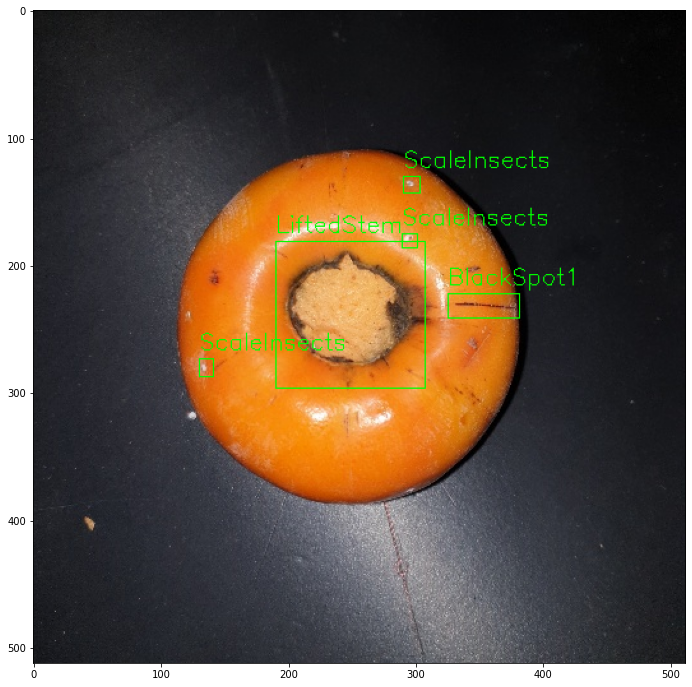

In [17]:
import matplotlib.pyplot as plt
import cv2

img_rgb = cv2.cvtColor(cv2.imread(f'{path}/JPEGImages/persimmon.1.jpg'), cv2.COLOR_BGR2RGB)

bbox_names, bboxes = get_bboxes_from_xml(f'{path}/Annotations/persimmon.1.xml')
for box_name, box in zip(bbox_names, bboxes):
  cv2.rectangle(img_rgb, (box[0], box[1]), (box[2], box[3]), color=(0, 255, 0), thickness=1)
  cv2.putText(img_rgb, box_name, (int(box[0]), int(box[1] - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

In [18]:
import os
ANNO_DIR = f'{path}/Annotations'  
file_list = os.listdir(ANNO_DIR)
xml_files = sorted([file for file in file_list if file.endswith('.xml')])
print('xml file list:', xml_files)
print('xml file 개수:', len(xml_files))

xml file list: ['persimmon.1.xml', 'persimmon.10.xml', 'persimmon.100.xml', 'persimmon.1000.xml', 'persimmon.1001.xml', 'persimmon.1002.xml', 'persimmon.1003.xml', 'persimmon.1004.xml', 'persimmon.1005.xml', 'persimmon.1006.xml', 'persimmon.1007.xml', 'persimmon.1008.xml', 'persimmon.1009.xml', 'persimmon.101.xml', 'persimmon.1010.xml', 'persimmon.1011.xml', 'persimmon.1012.xml', 'persimmon.1013.xml', 'persimmon.1014.xml', 'persimmon.1015.xml', 'persimmon.1016.xml', 'persimmon.1017.xml', 'persimmon.1018.xml', 'persimmon.1019.xml', 'persimmon.102.xml', 'persimmon.1020.xml', 'persimmon.1021.xml', 'persimmon.1022.xml', 'persimmon.1023.xml', 'persimmon.1024.xml', 'persimmon.1025.xml', 'persimmon.1026.xml', 'persimmon.1027.xml', 'persimmon.1028.xml', 'persimmon.1029.xml', 'persimmon.103.xml', 'persimmon.1030.xml', 'persimmon.1031.xml', 'persimmon.1032.xml', 'persimmon.1033.xml', 'persimmon.1034.xml', 'persimmon.1035.xml', 'persimmon.1036.xml', 'persimmon.1037.xml', 'persimmon.1038.xml', 'pe

### 개별 XML 정보와 이미지를 tf.train.Example로 변경하는 함수 생성. 
* https://github.com/google/automl/blob/master/efficientdet/dataset/create_pascal_tfrecord.py 참조

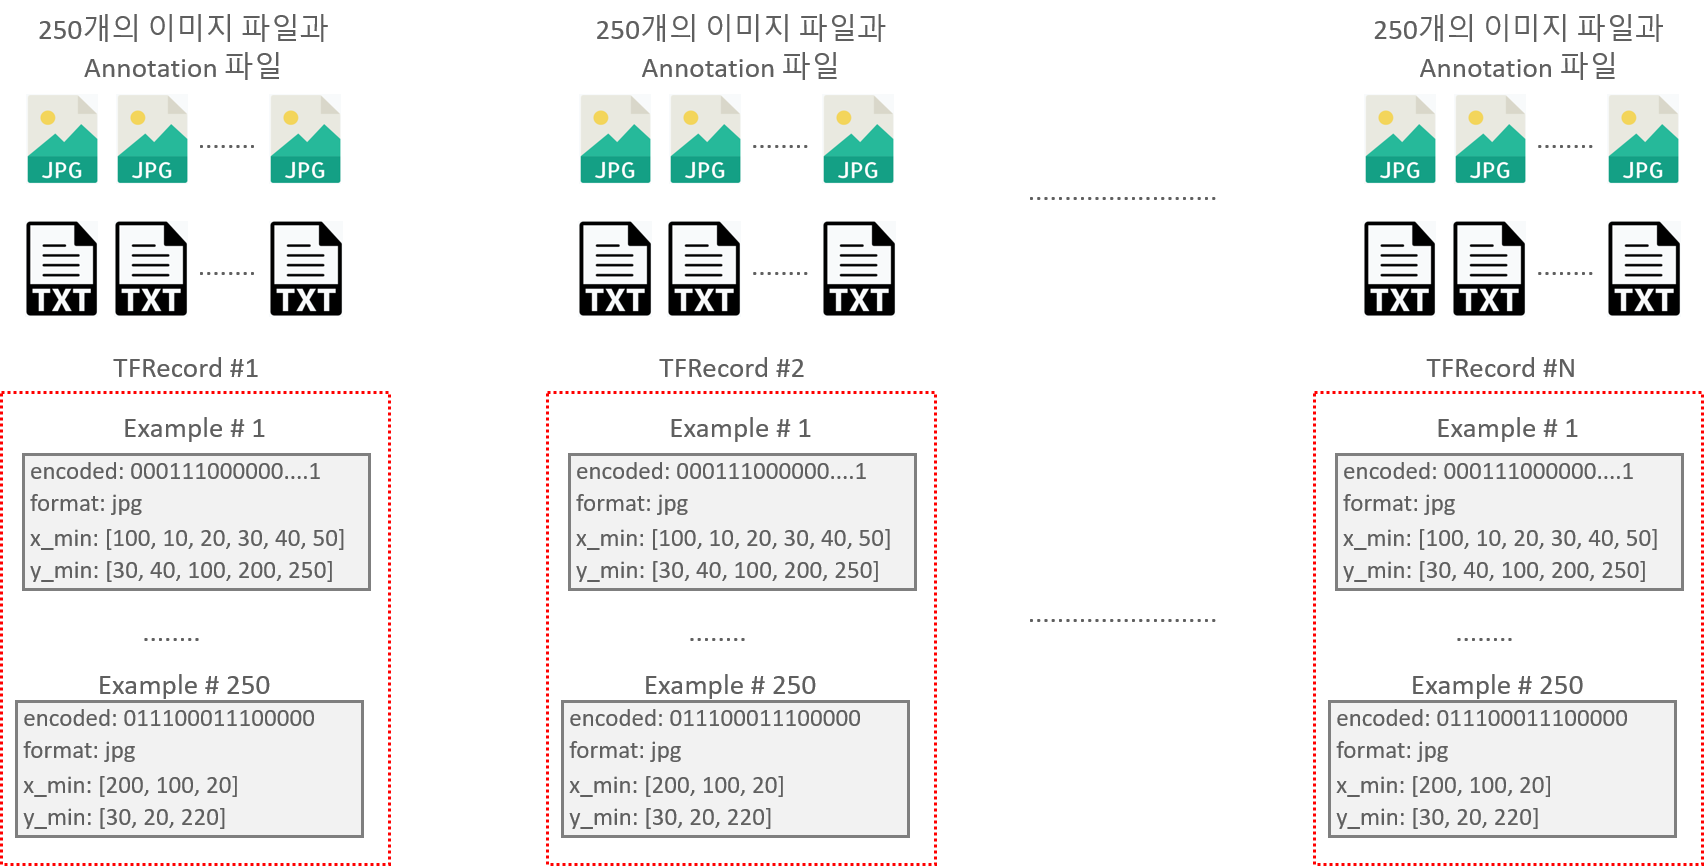

In [19]:
import xml.etree.ElementTree as ET

# xml 을 파싱해서 image와 object의 메타정보를 dict로 반환하는 함수 
def get_anno_dict_from_xml(xml_filepath):
  tree = ET.parse(xml_filepath)
  root = tree.getroot()
  bbox_names = []
  objects = []

  filename = root.find('filename').text
  size = root.find('size')
  width = int(size.find('width').text)
  height = int(size.find('height').text)

  # 파일내에 있는 모든 object Element를 찾음. 
  for obj in root.findall('object'):
    name = obj.find('name').text
    pose = 'Unspecified'
    #truncated, poses, difficult_obj는 사용되지 않지만 create_pascal_voc.py 파일과의 호환성을 유지하기 위해 설정. 
    truncated = 0
    difficult = 0
    occluded = 0

    #pose = obj.find('pose').text
    #truncated = int(obj.find('truncated').text)
    #difficult = int(obj.find('difficult').text)
    #occluded = int(obj.find('occluded').text)

    xmlbox = obj.find('bndbox')
    # 위치 좌표가 소수점까지 표시됨. pixel 단위는 정수형이므로 변환하되 ceil로 조금 이동하여 변환
    xmin = math.ceil(float(xmlbox.find('xmin').text))
    ymin = math.ceil(float(xmlbox.find('ymin').text))
    xmax = math.ceil(float(xmlbox.find('xmax').text))
    ymax = math.ceil(float(xmlbox.find('ymax').text))
    bbox = {
        'xmin': xmin, 
        'ymin': ymin, 
        'xmax': xmax, 
        'ymax': ymax
        }
    
    single_obj = {'name':name, 'pose':pose, 'truncated':truncated, 'difficult':difficult, 'occluded':occluded,
              'bndbox':bbox}
    objects.append(single_obj)

  anno_dict = {
      'folder':'training_data', 'filename':filename, 'width':width, 'height':height,
      'object':objects
  }

  return anno_dict

In [20]:
anno_dict = get_anno_dict_from_xml(f'{path}/Annotations/persimmon.1.xml')
anno_dict

{'filename': 'persimmon.1.jpg',
 'folder': 'training_data',
 'height': 512,
 'object': [{'bndbox': {'xmax': 141, 'xmin': 130, 'ymax': 287, 'ymin': 273},
   'difficult': 0,
   'name': 'ScaleInsects',
   'occluded': 0,
   'pose': 'Unspecified',
   'truncated': 0},
  {'bndbox': {'xmax': 301, 'xmin': 289, 'ymax': 186, 'ymin': 175},
   'difficult': 0,
   'name': 'ScaleInsects',
   'occluded': 0,
   'pose': 'Unspecified',
   'truncated': 0},
  {'bndbox': {'xmax': 303, 'xmin': 290, 'ymax': 143, 'ymin': 130},
   'difficult': 0,
   'name': 'ScaleInsects',
   'occluded': 0,
   'pose': 'Unspecified',
   'truncated': 0},
  {'bndbox': {'xmax': 381, 'xmin': 325, 'ymax': 241, 'ymin': 222},
   'difficult': 0,
   'name': 'BlackSpot1',
   'occluded': 0,
   'pose': 'Unspecified',
   'truncated': 0},
  {'bndbox': {'xmax': 307, 'xmin': 190, 'ymax': 296, 'ymin': 181},
   'difficult': 0,
   'name': 'LiftedStem',
   'occluded': 0,
   'pose': 'Unspecified',
   'truncated': 0}],
 'width': 512}

In [21]:
# image와 object의 고유 id 부여. 
class Unique_Id(object):
  
  def __init__(self):
    self.image_id = 0
    self.ann_id = 0

  def get_image_id(self):
    self.image_id += 1
    return self.image_id

  def get_ann_id(self):
    self.ann_id += 1
    return self.ann_id


In [22]:
# https://github.com/google/automl/blob/master/efficientdet/dataset/create_pascal_tfrecord.py 참조

import hashlib
import io
import json
import os
import PIL.Image
import tensorflow as tf
from dataset import tfrecord_util

# 1개의 image 파일 PATH와 1개의 annotation XML 정보를 가지는 data dic를 이용하여 tf.train.Example를 생성. 
def dict_to_tf_example(data, image_path, label_map_dict, unique_id, ignore_difficult_instances=False, ann_json_dict=None, debug=True):
  ''' 
    data는  1개의 xml 파일을 dictionary로 변환 anno_dict,
    image는 1개의 xml에 매핑되는 image 파일의 절대 경로
    unique_id는 고유한 image와 object id를 만들기 위한 Unique_Id객체
  ''' 
  
  #JPEG image를 binary 그대로 읽음. 
  with tf.io.gfile.GFile(image_path, 'rb') as fid:
    encoded_jpg = fid.read()
  
  # image가 JPEG 타입인지 확인. 
  encoded_jpg_io = io.BytesIO(encoded_jpg)
  image = PIL.Image.open(encoded_jpg_io)
  if image.format != 'JPEG':
    raise ValueError('Image format not JPEG')
  
  # image의 고유 key값 생성. 
  key = hashlib.sha256(encoded_jpg).hexdigest()

  #고유한 image id를 생성. 
  image_id = unique_id.get_image_id()
  # image의 width와 height 가져옴. 
  width = data['width']
  height = data['height']
 
  xmins, ymins, xmaxes, ymaxes = [], [], [], []
  areas, classes, classes_texts = [], [], []
  truncated, poses, difficult_obj = [], [], []
  # 만일 annotation에 1개 이상의 object가 있다면, 
  if 'object' in data:
    # data(anno_dict)의 'object' key값으로 개별 object 별 annotation 정보를 dict로 가지는 list로 구성. 이 list를 iteration 수행. 
    for obj in data['object']:
      difficult = bool(int(obj['difficult']))
      if ignore_difficult_instances and difficult:
        continue
      # object 명이 '1', '2'가 아니면 제외. 
      if obj['name'] not in label_map_dict:
        continue

      difficult_obj.append(int(difficult))
      # 개별 좌표 값을 이미지의 크기로 정규화하고 list로 저장. 
      xmins.append(float(obj['bndbox']['xmin']) / width)
      ymins.append(float(obj['bndbox']['ymin']) / height)
      xmaxes.append(float(obj['bndbox']['xmax']) / width)
      ymaxes.append(float(obj['bndbox']['ymax']) / height)
      areas.append((xmaxes[-1] - xmins[-1]) * (ymaxes[-1] - ymins[-1]))
      # class명과 class_id를 list로 저장. 
      classes_texts.append(obj['name'].encode('utf8'))
      classes.append(label_map_dict[obj['name']])
      # truncated, poses, difficult_obj는 사용되지 않지만 create_pascal_voc.py 파일과의 호환성을 유지하기 위해 저장. 
      truncated.append(int(obj['truncated']))
      poses.append(obj['pose'].encode('utf8'))
      difficult_obj.append(obj['difficult'])

  example_dict = {'height':height, 'width':width, 'filename':data['filename'].encode('utf8'),
                  'source_id': str(image_id).encode('utf8'), 'key_sha256': key.encode('utf8'),
                  'encoded': encoded_jpg, 'format':'jpeg'.encode('utf8'),
                  'xmin':xmins, 'xmax':xmaxes, 'ymin':ymins, 'ymax':ymaxes,
                  'area':areas, 'class_text':classes_texts, 'class_label':classes,
                  'difficult':difficult_obj, 'truncated':truncated, 'poses':poses}
  if debug:
   print('example_dict:', example_dict) 

  example = make_tfrecord_example(example_dict)

  return example

In [23]:
import tensorflow as tf
from dataset import tfrecord_util

# 인자로 들어온 dict에 따라 tf.train.Example을 생성. 
def make_tfrecord_example(example_dict):
  example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'image/height': tfrecord_util.int64_feature(example_dict['height']),
                'image/width': tfrecord_util.int64_feature(example_dict['width']),
                'image/filename': tfrecord_util.bytes_feature(example_dict['filename']),
                'image/source_id': tfrecord_util.bytes_feature(example_dict['source_id']),
                'image/key/sha256': tfrecord_util.bytes_feature(example_dict['key_sha256']),
                'image/encoded': tfrecord_util.bytes_feature(example_dict['encoded']),
                'image/format': tfrecord_util.bytes_feature('jpeg'.encode('utf8')),
                'image/object/bbox/xmin': tfrecord_util.float_list_feature(example_dict['xmin']),
                'image/object/bbox/xmax': tfrecord_util.float_list_feature(example_dict['xmax']),
                'image/object/bbox/ymin': tfrecord_util.float_list_feature(example_dict['ymin']),
                'image/object/bbox/ymax': tfrecord_util.float_list_feature(example_dict['ymax']),
                'image/object/area': tfrecord_util.float_list_feature(example_dict['area']),
                'image/object/class/text': tfrecord_util.bytes_list_feature(example_dict['class_text']),
                'image/object/class/label': tfrecord_util.int64_list_feature(example_dict['class_label']),
                'image/object/difficult': tfrecord_util.int64_list_feature(example_dict['difficult']),
                'image/object/truncated': tfrecord_util.int64_list_feature(example_dict['truncated']),
                'image/object/view': tfrecord_util.bytes_list_feature(example_dict['poses']),
            }))
  
  return example


In [24]:
label_map_dict = {
    'Anthrax': 1,
    'LiftedStem': 2,
    'StinkBug': 3,
    'Wounds': 4,
    'BlackSpot1': 5,
    'BlackSpot2': 6,
    'BlackSpot3': 7,
    'ScaleInsects': 8
}

# 테스트 용도로 한개의 Example 생성해 보기 
unique_id = Unique_Id()
data = get_anno_dict_from_xml(f'{path}/Annotations/persimmon.1.xml')
print('## xml 파일을 data dic로 변경 결과:', data)
image_path = f'{path}/JPEGImages/persimmon.1.jpg'

example = dict_to_tf_example(data, image_path, label_map_dict, unique_id, ignore_difficult_instances=False, ann_json_dict=None)

## xml 파일을 data dic로 변경 결과: {'folder': 'training_data', 'filename': 'persimmon.1.jpg', 'width': 512, 'height': 512, 'object': [{'name': 'ScaleInsects', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'occluded': 0, 'bndbox': {'xmin': 130, 'ymin': 273, 'xmax': 141, 'ymax': 287}}, {'name': 'ScaleInsects', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'occluded': 0, 'bndbox': {'xmin': 289, 'ymin': 175, 'xmax': 301, 'ymax': 186}}, {'name': 'ScaleInsects', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'occluded': 0, 'bndbox': {'xmin': 290, 'ymin': 130, 'xmax': 303, 'ymax': 143}}, {'name': 'BlackSpot1', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'occluded': 0, 'bndbox': {'xmin': 325, 'ymin': 222, 'xmax': 381, 'ymax': 241}}, {'name': 'LiftedStem', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'occluded': 0, 'bndbox': {'xmin': 190, 'ymin': 181, 'xmax': 307, 'ymax': 296}}]}
example_dict: {'height': 512, 'width': 512, 'filename': b'persimmon.1.jpg', 

In [25]:
example

features {
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\377\300\000\021\010\002\000\002\000\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#B\261\301\025R\321\360$3br\202\t\n\026\027\030\031\032%&\'()*4

### 학습과 검증용 TFRecord 파일들을 생성. 
* 학습과 검증용 DataFrame으로 학습, 검증 데이터세트 분류
* 개별 Example을 생성하는 dict_to_tf_example()을 이용하여 모든 데이터 세트를 TFRecord로 생성. 

In [26]:
file_id_list1 = [xml_file[:xml_file.rfind('.xml')] for xml_file in os.listdir(f'{path}/Annotations') \
                if '.xml' in xml_file]
file_id_dict = {}
for item in file_id_list1:
  splitItem = item.split('.')
  file_id_dict.update({int(splitItem[1]):item})
print(file_id_list1)
len(file_id_list1)

['persimmon.1451', 'persimmon.1500', 'persimmon.297', 'persimmon.1427', 'persimmon.224', 'persimmon.952', 'persimmon.1372', 'persimmon.1043', 'persimmon.1074', 'persimmon.600', 'persimmon.1382', 'persimmon.1469', 'persimmon.345', 'persimmon.1313', 'persimmon.931', 'persimmon.141', 'persimmon.199', 'persimmon.408', 'persimmon.1701', 'persimmon.1329', 'persimmon.1302', 'persimmon.46', 'persimmon.793', 'persimmon.44', 'persimmon.1045', 'persimmon.448', 'persimmon.619', 'persimmon.1536', 'persimmon.362', 'persimmon.1340', 'persimmon.1374', 'persimmon.155', 'persimmon.1397', 'persimmon.688', 'persimmon.1533', 'persimmon.742', 'persimmon.201', 'persimmon.1391', 'persimmon.1593', 'persimmon.549', 'persimmon.1235', 'persimmon.947', 'persimmon.451', 'persimmon.1059', 'persimmon.1527', 'persimmon.1306', 'persimmon.358', 'persimmon.906', 'persimmon.1473', 'persimmon.185', 'persimmon.1120', 'persimmon.472', 'persimmon.124', 'persimmon.1078', 'persimmon.853', 'persimmon.62', 'persimmon.1067', 'pers

1708

In [27]:
file_id_list2 = sorted(file_id_dict.items())
file_id_list = []
for key, value in file_id_list2:
  file_id_list.append(value)
print(file_id_list)

['persimmon.1', 'persimmon.2', 'persimmon.3', 'persimmon.4', 'persimmon.5', 'persimmon.6', 'persimmon.7', 'persimmon.8', 'persimmon.9', 'persimmon.10', 'persimmon.11', 'persimmon.12', 'persimmon.13', 'persimmon.14', 'persimmon.15', 'persimmon.16', 'persimmon.17', 'persimmon.18', 'persimmon.19', 'persimmon.20', 'persimmon.21', 'persimmon.22', 'persimmon.23', 'persimmon.24', 'persimmon.25', 'persimmon.26', 'persimmon.27', 'persimmon.28', 'persimmon.29', 'persimmon.30', 'persimmon.31', 'persimmon.32', 'persimmon.33', 'persimmon.34', 'persimmon.35', 'persimmon.36', 'persimmon.37', 'persimmon.38', 'persimmon.39', 'persimmon.40', 'persimmon.41', 'persimmon.42', 'persimmon.43', 'persimmon.44', 'persimmon.45', 'persimmon.46', 'persimmon.47', 'persimmon.48', 'persimmon.49', 'persimmon.50', 'persimmon.51', 'persimmon.52', 'persimmon.53', 'persimmon.54', 'persimmon.55', 'persimmon.56', 'persimmon.57', 'persimmon.58', 'persimmon.59', 'persimmon.60', 'persimmon.61', 'persimmon.62', 'persimmon.63', 

In [28]:
import pandas as pd

pd.set_option('display.max_colwidth', 300)
data_df = pd.DataFrame({'file_id': file_id_list})
data_df['image_path'] = f'{path}/JPEGImages/' + data_df['file_id'] + '.jpg'
data_df['xml_path'] = f'{path}/Annotations/' + data_df['file_id'] + '.xml'

print(data_df.shape)
data_df.head()

(1708, 3)


,file_id,image_path,xml_path
0,persimmon.1,/content/persimmonAug/JPEGImages/persimmon.1.jpg,/content/persimmonAug/Annotations/persimmon.1.xml
1,persimmon.2,/content/persimmonAug/JPEGImages/persimmon.2.jpg,/content/persimmonAug/Annotations/persimmon.2.xml
2,persimmon.3,/content/persimmonAug/JPEGImages/persimmon.3.jpg,/content/persimmonAug/Annotations/persimmon.3.xml
3,persimmon.4,/content/persimmonAug/JPEGImages/persimmon.4.jpg,/content/persimmonAug/Annotations/persimmon.4.xml
4,persimmon.5,/content/persimmonAug/JPEGImages/persimmon.5.jpg,/content/persimmonAug/Annotations/persimmon.5.xml


In [29]:
from sklearn.model_selection import train_test_split

# 전체 데이터의 20%를 검증용으로 할당. 
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=2021)
print(train_df.shape, val_df.shape)

(1366, 3) (342, 3)


In [30]:
# 모든 image/xml 파일들을 TFRecord로 생성. 
def make_tfrecords(meta_df, output_dir, output_prefix, num_shards):
  '''
  meta_df: train/val DataFrame에서 입력 xml과 image의 경로를 가져옴. 
  output_dir: 출력 TFRecord가 저장될 directory
  output_prefix: 출력 TFRecord 파일의 prefix명. 
  num_shards: 만들어질 TFRecord 파일의 수
  '''
  xml_list = meta_df['xml_path'].to_list()
  image_list = meta_df['image_path'].to_list()

  unique_id = Unique_Id()
  # num_shards 만큼의 TFRecordWriter객체 생성. 
  writers = [
        tf.io.TFRecordWriter(output_dir + output_prefix +'-%05d-of-%05d.tfrecord' %
                            (i, num_shards))
        for i in range(num_shards)
    ]
  #xml 개수만큼 iteration을 돌려서 Example을 만들고 개별 Example을 특정 shard에 해당하는 TFRecord에 append
  for idx, xml_path in enumerate(xml_list):
    if idx % 100 == 0:
      print('On image ', idx, 'of ', len(xml_list))
    
    data = get_anno_dict_from_xml(xml_path)
    image_path = image_list[idx]
    # 개별 Example 생성. 
    tf_example = dict_to_tf_example(data, image_path, label_map_dict, unique_id, 
                                    ignore_difficult_instances=False, ann_json_dict=None, debug=False)
    # num_shard만큼 만들어진 TFRecord에 Example을 iteration을 수행하면서 해당하는 TFRecord로 append 
    writers[idx % num_shards].write(tf_example.SerializeToString())
  
  # num_shards 만큼 만들어진 TFRecordWriter 객체 close
  for writer in writers:
    writer.close()

In [31]:
!mkdir -p /content/tfrecord/train
!mkdir -p /content/tfrecord/val

In [32]:
print('#### train용 tfrecords 생성 시작 ####')
make_tfrecords(train_df, '/content/tfrecord/train/', 'train', num_shards=100)

print('#### val용 tfrecords 생성 시작 ####')
make_tfrecords(val_df, '/content/tfrecord/val/', 'val', num_shards=100)

#### train용 tfrecords 생성 시작 ####
On image  0 of  1366
On image  100 of  1366
On image  200 of  1366
On image  300 of  1366
On image  400 of  1366
On image  500 of  1366
On image  600 of  1366
On image  700 of  1366
On image  800 of  1366
On image  900 of  1366
On image  1000 of  1366
On image  1100 of  1366
On image  1200 of  1366
On image  1300 of  1366
#### val용 tfrecords 생성 시작 ####
On image  0 of  342
On image  100 of  342
On image  200 of  342
On image  300 of  342


In [33]:
!ls -lia /content/tfrecord/train
!ls -lia /content/tfrecord/val

total 94920
5250203 drwxr-xr-x 2 root root    4096 Mar  5 02:49 .
5250202 drwxr-xr-x 4 root root    4096 Mar  5 02:49 ..
5250205 -rw-r--r-- 1 root root  925577 Mar  5 02:49 train-00000-of-00100.tfrecord
5250206 -rw-r--r-- 1 root root  962464 Mar  5 02:49 train-00001-of-00100.tfrecord
5250207 -rw-r--r-- 1 root root  990759 Mar  5 02:49 train-00002-of-00100.tfrecord
5250208 -rw-r--r-- 1 root root 1024344 Mar  5 02:49 train-00003-of-00100.tfrecord
5250209 -rw-r--r-- 1 root root  937102 Mar  5 02:49 train-00004-of-00100.tfrecord
5250210 -rw-r--r-- 1 root root 1006516 Mar  5 02:49 train-00005-of-00100.tfrecord
5250211 -rw-r--r-- 1 root root 1028583 Mar  5 02:49 train-00006-of-00100.tfrecord
5250212 -rw-r--r-- 1 root root  997558 Mar  5 02:49 train-00007-of-00100.tfrecord
5250213 -rw-r--r-- 1 root root  937903 Mar  5 02:49 train-00008-of-00100.tfrecord
5250214 -rw-r--r-- 1 root root  935409 Mar  5 02:49 train-00009-of-00100.tfrecord
5250215 -rw-r--r-- 1 root root  984475 Mar  5 02:49 train-0

### Pretrained 모델을 다운로드 받고 Train을 위한 config 생성
* pretrained 모델은 efficientdet-d2
* num_classes는 2, max_instances_per_image는 기본 100개임. 1개의 이미지에  특정 object의 갯수가 100개를 초과하는 경우가 있음.  max_instances_per_image = 200 으로 수정. 

In [34]:
# epochs시마다 학습된 weight파일을 저장한 디렉토리 Google drive로 설정. 
# Google Drive 접근을 위한 Mount 적용. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

# soft link로 Google Drive Directory 연결. 
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive
!mkdir -p /mydrive/model_trained_d3

Mounted at /content/gdrive
 00_문서자료
 01_이미지데이터
 02_코랩
 03_논문
 04_과제
 05_발표준비
 데이콘경진대회1등솔루션.pdf
'수집 대상 데이터 분석_수치 항목 필터링_매칭작업_20210928.xlsx'
'수집대상 포인트 그룹_명칭 정의 중_20210928_수정.xlsx'
 2108.06453.gdoc
'단감 품질 선별을 위한 혼합 2단계 CNN 모델과 CAM 시각화_최종.hwp'
'합성곱 신경망과 CAM 기반의 단감 품질 선별.gdoc'
'Colab Notebooks'
 CV예시__password_pass.docx
'EfficentDet과 Pycaret을 이용한 단감 등급 선별211229_2.hwp'
'EfficentDet과 Pycaret을 이용한 단감 등급 선별211229.hwp'
'EfficentDet과 Pycaret을 이용한 단감 등급 선별220119.hwp'
'EfficientDet을 사용한 Fire Detection 알고리즘과 문자 전송 시스템 (1).pdf'
 EfficientDet.pptx
'Efficient Federated Meta-Learning over________.pdf'
 EMS_20211101
 logs
 model_trained
 model_trained_d1_220227
 model_trained_d2_220222
 model_trained_d3
 model_trained_d3_220227
 model_trained_d4
 model_traine

In [35]:
number ='3'
MODEL = f'efficientdet-d{number}' 

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
print('Use model in {}'.format(ckpt_path))

--2022-03-05 02:49:26--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d3.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.128, 172.217.193.128, 108.177.13.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89259783 (85M) [application/octet-stream]
Saving to: ‘efficientdet-d3.tar.gz’

efficientdet-d3.tar 100%[===================>]  85.12M   136MB/s    in 0.6s    

2022-03-05 02:49:27 (136 MB/s) - ‘efficientdet-d3.tar.gz’ saved [89259783/89259783]

Use model in /content/efficientdet-d3


In [36]:
class TRAIN_CFG:
  model_name = f'efficientdet-d{number}' # efficientdet 모델명
  strategy = '' # tpu, 여러개의 GPU들, 단일 GPU 일때 학습 strategy 설정. 
  model_dir = f'/mydrive/model_trained_d{number}_220305' # 학습된 모델이 저장될 위치
  pretrained_ckpt = f'/content/efficientdet-d{number}' # coco로 pretrained된 checkpoint 파일이 있는 디렉토리 위치
  # num_classes는 8개임. 
  hparams = 'num_classes=8,moving_average_decay=0,mixed_precision=true'
  use_xla = False
  use_fake_data = False
  # max_instances_per_image를 200으로 설정하고, D2 모델이 상대적으로 더 크기 때문에 batch_size를 8로 설정시 GPU Out of Memory 발생 
  batch_size = 2
  eval_samples = 1000 # evaluation image 데이터 갯수
  steps_per_execution = 1 # train 시 steps 횟수
  num_examples_per_epoch = 500 # 1 epochs 시 적용하는 examples 개수 
  num_epochs = 20 # epochs 횟수
  train_file_pattern = '/content/tfrecord/train/train-*.tfrecord' # 학습용 tfrecords를 glob 형태로 가져오는 표현식. 
  val_file_pattern = '/content/tfrecord/val/val-*.tfrecord' # 검증용 tfrecords를 glob 형태로 가져오는 표현식. 
  val_json_file = None # optional coco validation json 
  mode = 'traineval' # train만 적용 또는 train과 eval함께 적용(traineval)
  num_shards = 100 # 
  # max_instances_per_image는 기본 100개임. 1개의 이미지에  특정 object의 갯수가 100개를 초과하는 경우가 있음. 200으로 수정. 
  max_instances_per_image = 200
  
  num_cores = 2 # tpu 일때 8 적용.  
  tpu = None
  gcp_project = None
  tpu_zone = None
  eval_master = ''
  eval_name = None
  tf_random_seed = 2021
  profile = False
  debug = False

In [37]:
!pip install tensorflow_model_optimization

     |████████████████████████████████| 234 kB 5.0 MB/s 


In [38]:
from tf2.train import setup_model
import hparams_config

import utils
from tf2 import tfmot
from tf2 import train_lib
from tf2 import util_keras

config = hparams_config.get_detection_config(TRAIN_CFG.model_name)
config.override(TRAIN_CFG.hparams)

steps_per_epoch = TRAIN_CFG.num_examples_per_epoch // TRAIN_CFG.batch_size

if tf.config.list_physical_devices('GPU'):
  ds_strategy = tf.distribute.OneDeviceStrategy('device:GPU:0')
else:
  ds_strategy = tf.distribute.OneDeviceStrategy('device:CPU:0')

print(ds_strategy)

params = dict(
      profile=TRAIN_CFG.profile,
      mode = TRAIN_CFG.mode,
      model_name=TRAIN_CFG.model_name,
      steps_per_execution=TRAIN_CFG.steps_per_execution,
      num_epochs = TRAIN_CFG.num_epochs,
      model_dir=TRAIN_CFG.model_dir,
      steps_per_epoch=steps_per_epoch,
      strategy=TRAIN_CFG.strategy,
      batch_size=TRAIN_CFG.batch_size,
      tf_random_seed=TRAIN_CFG.tf_random_seed,
      debug=TRAIN_CFG.debug,
      val_json_file=TRAIN_CFG.val_json_file,
      eval_samples=TRAIN_CFG.eval_samples,
      num_shards=ds_strategy.num_replicas_in_sync,
      # max_instances_per_image는 기본 100개임. 1개의 이미지에  특정 object의 갯수가 100개를 초과하는 경우가 있음. 200으로 수정.
      max_instances_per_image = TRAIN_CFG.max_instances_per_image
      )

config.override(params, True)

# image size를 tuple 형태로 변환. 512는 (512, 512)로 '1920x880' 은 (1920, 880) 으로 변환.  
config.image_size = utils.parse_image_size(config.image_size)
print(config)

act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b3
batch_size: 2
box_class_repeats: 4
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
debug: false
delta: 0.1
drop_remainder: true
eval_samples: 1000
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 6
fpn_config: null
fpn_name: null
fpn_num_filters: 160
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: !!python/tuple
- 896
- 896
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: true
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_insta

In [39]:
import utils
from tf2 import tfmot
from tf2 import train_lib
from tf2 import util_keras
# P100에서는 적용할 필요 없음. 
'''
precision = utils.get_precision(config.strategy, config.mixed_precision)
policy = tf.keras.mixed_precision.Policy(precision)
tf.keras.mixed_precision.set_global_policy(policy)
'''

'\nprecision = utils.get_precision(config.strategy, config.mixed_precision)\npolicy = tf.keras.mixed_precision.Policy(precision)\ntf.keras.mixed_precision.set_global_policy(policy)\n'

### Dataset과 Model 생성하고 학습 수행. 
* 앞에서 만든 train과 val용 TFRecord를 이용하여 dataloader.InputReader를 생성하는 함수 생성.
* efficientdet-d2 모델 생성 후 pretrained 모델의 weight 전이.
* batch_size 4로 설정. 8로 설정 시 GPU Memory OOM 발생 가능성 높음(Out Of Memory), epochs 20으로 학습 수행. 

In [40]:
import dataloader

def get_dataset(is_training, config):
  # is_training이 True이면 TRAIN_CFG의 train_file_pattern, 그렇지 아니면 val_file_pattern
  file_pattern = (
    TRAIN_CFG.train_file_pattern
    if is_training else TRAIN_CFG.val_file_pattern)
  if not file_pattern:
    raise ValueError('No matching files.')

  return dataloader.InputReader(
    file_pattern,
    is_training=is_training,
    use_fake_data=TRAIN_CFG.use_fake_data,
    max_instances_per_image=config.max_instances_per_image,
    debug=TRAIN_CFG.debug)(
        config.as_dict())

In [41]:
from tf2 import train_lib
from tf2 import train

def get_efficientdet_model(config):
  # 2개의 class를 가진 efficientdet d2 모델을 생성. 
  model = train_lib.EfficientDetNetTrain(config=config)
  model = train.setup_model(model, config)
  # 만약 pretrained 모델이 있으면, 해당 checkpoint weight를 모델로 로딩. 이때 classification layer는 제외. 
  #class TRAIN_CFG: pretrained_ckpt = '/content/efficientdet-d2' 
  if TRAIN_CFG.pretrained_ckpt:
    ckpt_path = tf.train.latest_checkpoint(TRAIN_CFG.pretrained_ckpt)
    # classfication layer를 제외하고 pretrained weight를 생성된 모델로 로딩. 
    util_keras.restore_ckpt(
        model,
        ckpt_path,
        config.moving_average_decay,
        exclude_layers=['class_net'])
    
  train.init_experimental(config)
  return model

model = get_efficientdet_model(config)
model.summary()

/content/automl/efficientdet/utils.py:23: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  from tensorflow.python.tpu import tpu_function  # pylint:disable=g-direct-tensorflow-import
/content/automl/efficientdet/utils.py:255: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  for u in self.updates:


Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Model)     multiple                  10187560  
                                                                 
 resample_p6 (ResampleFeatur  multiple                 62240     
 eMap)                                                           
                                                                 
 resample_p7 (ResampleFeatur  multiple                 0         
 eMap)                                                           
                                                                 
 fpn_cells (FPNCells)        multiple                  1514514   
                                                                 
 class_net (ClassNet)        multiple                  134632    
                                                                 
 box_net (BoxNet)            multiple                  128836    


In [42]:
print(config.mode)

traineval


In [43]:
from tf2 import train
import numpy as np

config.batch_size = 2
tr_steps_per_epoch = train_df.shape[0]//config.batch_size
val_steps_per_epoch = val_df.shape[0]//config.batch_size
print('tr_steps_per_epoch:', tr_steps_per_epoch, 'val_steps_per_epoch:', val_steps_per_epoch)

val_dataset = get_dataset(False, config) if 'eval' in config.mode else None

model.fit(
    get_dataset(True, config),
    epochs=60,
    steps_per_epoch=tr_steps_per_epoch,
    callbacks=train_lib.get_callbacks(config.as_dict(), val_dataset),
    validation_data=val_dataset,
    validation_steps=val_steps_per_epoch)

tf.keras.backend.clear_session()

tr_steps_per_epoch: 683 val_steps_per_epoch: 171
Epoch 1/60


/content/automl/efficientdet/utils.py:23: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  from tensorflow.python.tpu import tpu_function  # pylint:disable=g-direct-tensorflow-import
/content/automl/efficientdet/utils.py:255: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  for u in self.updates:


683/683 [==============================] - ETA: 0s - det_loss: 49.5461 - cls_loss: 49.1707 - box_loss: 0.0075 - reg_l2_loss: 0.0990 - loss: 49.6452 - learning_rate: 0.0035 - gradient_norm: 6.6974
Epoch 1: saving model to /mydrive/model_trained_d3_220305/ckpt-1
683/683 [==============================] - 679s 883ms/step - det_loss: 49.4759 - cls_loss: 49.1001 - box_loss: 0.0075 - reg_l2_loss: 0.0990 - loss: 49.5749 - learning_rate: 0.0035 - gradient_norm: 6.7022 - val_det_loss: 1.1024 - val_cls_loss: 0.8524 - val_box_loss: 0.0050 - val_reg_l2_loss: 0.0992 - val_loss: 1.2016
Epoch 2/60
683/683 [==============================] - ETA: 0s - det_loss: 0.9745 - cls_loss: 0.6885 - box_loss: 0.0057 - reg_l2_loss: 0.0993 - loss: 1.0738 - learning_rate: 0.0022 - gradient_norm: 6.7178
Epoch 2: saving model to /mydrive/model_trained_d3_220305/ckpt-2
683/683 [==============================] - 597s 873ms/step - det_loss: 0.9756 - cls_loss: 0.6887 - box_loss: 0.0057 - reg_l2_loss: 0.0993 - loss: 1.0749

### 학습된 모델 파일을 이용하여 Inference 수행.

In [ ]:
import sys

sys.path.append('/content/automl/efficientdet')

In [ ]:
import hparams_config

infer_config = hparams_config.get_efficientdet_config('efficientdet-d4')

# config의 특정 항목을 update
infer_config.model_name = 'efficientdet-d4'
infer_config.model_dir = '/mydrive/model_trained_d4'
# infer_config의 num_classes는 2로 바뀌어야 함. 
infer_config.num_classes = 7
infer_config.is_training_bn = False
infer_config.nms_configs.score_thresh = 0.2

print(infer_config)

In [ ]:
import inference
from tf2 import efficientdet_keras
import tensorflow as tf

model = efficientdet_keras.EfficientDetModel(config=infer_config)
model.build((None, None, None, 3))
print('#### checkpoint name:', tf.train.latest_checkpoint(infer_config.model_dir))
model.load_weights(tf.train.latest_checkpoint(infer_config.model_dir))
model.summary()

In [ ]:
import time

class ExportModel(tf.Module):

  def __init__(self, model):
    super().__init__()
    self.model = model

  @tf.function
  def f(self, imgs):
    #model(imgs, training=False, post_mode='global')
    return self.model(imgs, training=False, post_mode='global')

export_model = ExportModel(model)

In [ ]:
labels_to_names =  {1:'ScaleInsects', 2:'Anthrax', 3: 'LiftedStem', 4: 'StinkBug', 5: 'SoftPersimmon', 6: 'Wounds', 7: 'BlackSpot'}

In [ ]:
def get_detected_img(export_model, img_array, is_print=True):   
  # automl efficent은 반환 bbox 좌표값이 원본 이미지 좌표값으로 되어 있으므로 별도의 scaling작업 필요 없음. 
  '''
  height = img_array.shape[0]
  width = img_array.shape[1]
  '''
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(255, 0, 0)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet 모델을 다운로드 한 뒤 inference 수행. 
  start_time = time.time()
  # automl efficientdet 모델은 boxes, score, classes, num_detections를 각각 Tensor로 반환. 
  boxes, scores, classes, valid_len = export_model.f(img_tensor)
  # Tensor값을 시각화를 위해 numpy 로 변환. 
  boxes = boxes.numpy()
  scores = scores.numpy()
  classes = classes.numpy()
  valid_len = valid_len.numpy()
  
  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(valid_len[0]):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
    score = scores[0, i]
    
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = boxes[0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. 또한 원본 좌표값으로 되어 있음. '''
    left = box[1]
    top = box[0] 
    right = box[3] 
    bottom = box[2] 

    # class id 추출하고 class 명으로 매핑
    class_id = classes[0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=1)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.2, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_array = cv2.cvtColor(cv2.imread('/content/Persimmon/JPEGImages/Perssimon.270.jpg'), cv2.COLOR_BGR2RGB)

draw_img = get_detected_img(export_model, img_array, is_print=True)
plt.figure(figsize=(16, 16))
plt.imshow(draw_img)